In [1]:
#@title Install libs
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib

!pip install ccxt
!pip install mplfinance
!pip install pykalman

!pip install tqdm

!pip install hurst

--2024-11-08 14:35:16--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2024-11-08 14:35:17--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://psychz.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz?viasf=1 [following]
--2024-11-08 14:35:17--  http://psychz.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz?viasf=1
Resolving p

In [2]:
#@title Load libs
from datetime import datetime

#from functools import reduce
#from math import sqrt
import numpy as np
import pandas as pd
#from pandas import DataFrame
from tqdm import tqdm
#from freqtrade.persistence import Trade

import talib.abstract as ta

import ccxt
import mplfinance as mpf

from pykalman import KalmanFilter


from hurst import compute_Hc



In [3]:
#@title Helping functions
'''
def get_data(exch: str, start_time: str, timeframe: str, ticker: str) -> pd.DataFrame:
    #ex = ccxt.binance()
    ex = getattr (ccxt, exch) ()
    from_ts = ex.parse8601(start_time)
    #ohlcv_list = []
    ohlcv = ex.fetch_ohlcv(ticker, timeframe, since=from_ts, limit=1000)
    #ohlcv_list.append(ohlcv)
    while True:
        from_ts = ohlcv[-1][0]+1
        new_ohlcv = ex.fetch_ohlcv(ticker, timeframe, since=from_ts, limit=1000)
        ohlcv.extend(new_ohlcv)
        if len(new_ohlcv)!=1000:
          break
    df = pd.DataFrame(ohlcv, columns=['date', 'open', 'high', 'low', 'close', 'volume'])
    df['date'] = pd.to_datetime(df['date'], unit='ms')
    df.set_index('date', inplace=True)
    df = df.sort_index(ascending=True)
    return df
'''

def get_data(exch: str, start_time: str, end_time: str, timeframe: str, ticker: str) -> pd.DataFrame:
    ex = getattr(ccxt, exch)()
    from_ts = ex.parse8601(start_time)
    to_ts = ex.parse8601(end_time)

    ohlcv = ex.fetch_ohlcv(ticker, timeframe, since=from_ts, limit=1000)
    while True:
        from_ts = ohlcv[-1][0] + 1
        new_ohlcv = ex.fetch_ohlcv(ticker, timeframe, since=from_ts, limit=1000)
        ohlcv.extend(new_ohlcv)
        if len(new_ohlcv) != 1000 or new_ohlcv[-1][0] >= to_ts:
            break

    df = pd.DataFrame(ohlcv, columns=['date', 'open', 'high', 'low', 'close', 'volume'])
    df['date'] = pd.to_datetime(df['date'], unit='ms')
    df.set_index('date', inplace=True)
    df = df.sort_index(ascending=True)
    return df


def get_kalman(data: pd.DataFrame, column_name: str, new_column_name:str) -> pd.DataFrame:
    df=data.copy()
    kf = KalmanFilter(transition_matrices = [1],
                    observation_matrices = [1],
                    initial_state_mean = 0)#,
                    #initial_state_covariance = 1,
                    #observation_covariance=1,
                    #transition_covariance=.01)

    # Use the observed values of the price to get a rolling mean
    state_means, _ = kf.filter(df[column_name].values)
    state_means = pd.Series(state_means.flatten(), index=df[column_name].index)

    df[new_column_name]=state_means

    return df


def check_stat(result):
    l=[]
    w=[]
    d_stat=10000
    for i in result[1]:
      if i['deposit_stat']<d_stat:
        l.append(i)
      else:
        w.append(i)
      d_stat=i['deposit_stat']
    return l, w


In [4]:
EXCH = 'kraken' # @param ['binance','bitfinex','bytetrade','ftx','kraken','poloniex','upbit','acx','bequant','bigone','bitforex','bitkk','bitz','btcalpha','coinex','crex24','digifinex','gateio','hitbtc2','huobipro','huobiru','kucoin','lbank','okex','okex3','stex','upbit','whitebit','zb'] {allow-input: false}
START_DATE = "2024-01-01 00:00:00" #@param {type: "string"}
END_DATE = "2024-01-29 00:00:00" #@param {type: "string"}
TIMEFRAME= "1h" #@param {type: "string"}
TICKER= "BTC/USDT" #@param {type: "string"}
data = get_data(EXCH, START_DATE, END_DATE, TIMEFRAME, TICKER)
data.reset_index(inplace=True)

print(f'data len: {len(data)}')
print()
data.head()

data len: 720



,date,open,high,low,close,volume
0,2024-10-09 15:00:00,61824.9,62359.5,61819.1,62321.0,11.996139
1,2024-10-09 16:00:00,62328.9,62328.9,61723.3,61802.8,6.202276
2,2024-10-09 17:00:00,61803.8,61881.2,61589.4,61745.8,23.374163
3,2024-10-09 18:00:00,61749.7,61815.2,61177.8,61186.3,8.571221
4,2024-10-09 19:00:00,61188.1,61188.1,60841.7,61024.4,24.273918


Всего сделок: 79
Успешные сделки: 48
Процент успешных сделок: 60.76%
Общая доходность: 19.40%
Максимальная прибыль: 5.84%
Максимальный убыток: -2.67%
Средняя доходность: 0.83%
Медианная доходность: 0.62%
Средний убыток: -0.65%
Медианный убыток: -0.35%
Доходность рынка за период: 21.97%
Доходность стратегии за период: 19.40%


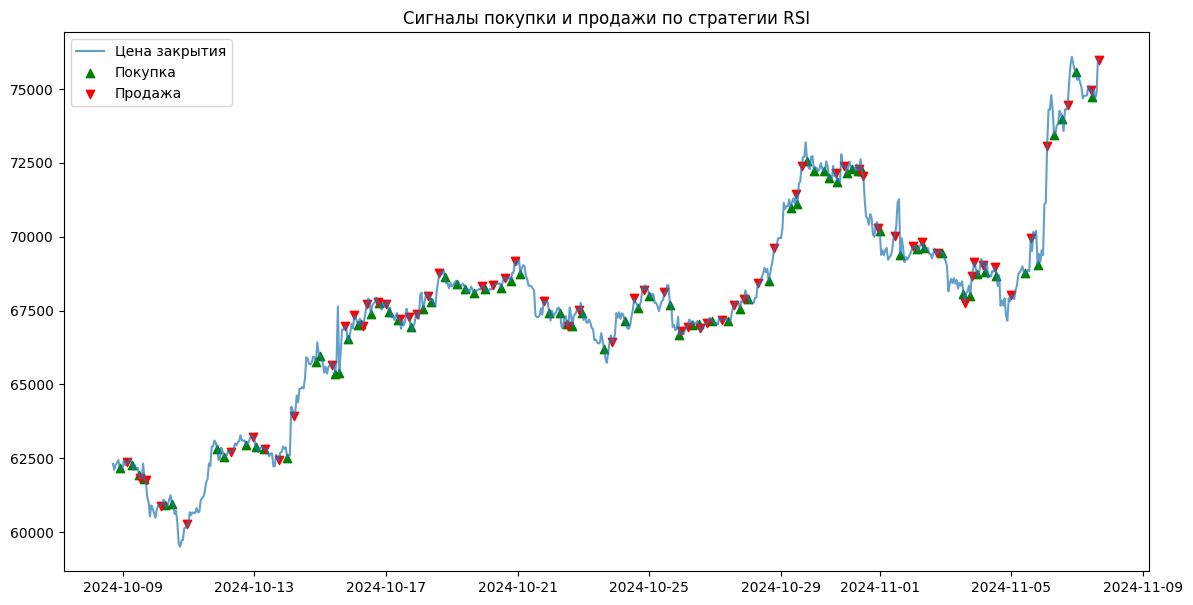

In [ ]:
import talib as ta
import pandas as pd
import numpy as np

# Параметры стратегии
RSI_PERIOD = 2
RSI_BUY_LEVEL = 36
RSI_SELL_LEVEL = 68
STOP_LOSS_RATIO = 0.045  # Стоп-лосс 0.45%
TAKE_PROFIT_RATIO = 0.03  # Тейк-профит 3%
EXIT_DELAY = 2  # Задержка выхода из позиции на N баров

# Загрузка данных (параметры можно настроить по своему усмотрению)
data = get_data('kraken', '2024-04-01T00:00:00Z', '2024-05-31T00:00:00Z', '1h', 'BTC/USDT')
data.reset_index(inplace=True)

# Рассчитываем RSI
data['RSI'] = ta.RSI(data['close'], timeperiod=RSI_PERIOD)

# Создаем столбцы для сигналов и результатов
data['signal'] = 0  # 1 — покупка, -1 — продажа, 0 — нет сигнала
data['price_entry'] = np.nan  # Цена входа в сделку
data['price_exit'] = np.nan  # Цена выхода
data['trade_result'] = np.nan  # Результат сделки в процентах

# Статусы для управления сделками
in_position = False
entry_price = 0

# Логика стратегии
for i in range(1, len(data)):
    if not in_position:  # Если мы не в позиции
        if data['RSI'][i] < RSI_BUY_LEVEL:  # Условие для покупки
            entry_price = data['close'][i]
            stop_loss = entry_price * (1 - STOP_LOSS_RATIO)
            take_profit = entry_price * (1 + TAKE_PROFIT_RATIO)
            data.at[i, 'signal'] = 1  # Сигнал на покупку
            data.at[i, 'price_entry'] = entry_price
            in_position = True
    else:  # Если мы в позиции
        # Проверяем, достигли ли стоп-лосса или тейк-профита
        if data['low'][i] <= stop_loss:  # Стоп-лосс
            exit_index = min(i + EXIT_DELAY, len(data) - 1)
            exit_price = data['close'][exit_index]
            data.at[exit_index, 'signal'] = -1  # Сигнал на продажу
            data.at[exit_index, 'price_exit'] = exit_price
            data.at[exit_index, 'trade_result'] = (exit_price - entry_price) / entry_price * 100
            in_position = False
        elif data['high'][i] >= take_profit:  # Тейк-профит
            exit_index = min(i + EXIT_DELAY, len(data) - 1)
            exit_price = data['close'][exit_index]
            data.at[exit_index, 'signal'] = -1  # Сигнал на продажу
            data.at[exit_index, 'price_exit'] = exit_price
            data.at[exit_index, 'trade_result'] = (exit_price - entry_price) / entry_price * 100
            in_position = False
        elif data['RSI'][i] > RSI_SELL_LEVEL:  # Продаем по RSI
            exit_index = min(i + EXIT_DELAY, len(data) - 1)
            exit_price = data['close'][exit_index]
            data.at[exit_index, 'signal'] = -1  # Сигнал на продажу
            data.at[exit_index, 'price_exit'] = exit_price
            data.at[exit_index, 'trade_result'] = (exit_price - entry_price) / entry_price * 100
            in_position = False

# Выводим результаты сделок
trades = data.dropna(subset=['trade_result'])
print(f"Всего сделок: {len(trades)}")
print(f"Успешные сделки: {len(trades[trades['trade_result'] > 0])}")
print(f"Процент успешных сделок: {len(trades[trades['trade_result'] > 0]) / len(trades) * 100:.2f}%")
print(f"Общая доходность: {trades['trade_result'].sum():.2f}%")
print(f"Максимальная прибыль: {trades['trade_result'].max():.2f}%")
print(f"Максимальный убыток: {trades['trade_result'].min():.2f}%")

# Средняя и медианная доходность и убыток
average_profit = trades[trades['trade_result'] > 0]['trade_result'].mean()
median_profit = trades[trades['trade_result'] > 0]['trade_result'].median()
average_loss = trades[trades['trade_result'] < 0]['trade_result'].mean()
median_loss = trades[trades['trade_result'] < 0]['trade_result'].median()

print(f"Средняя доходность: {average_profit:.2f}%")
print(f"Медианная доходность: {median_profit:.2f}%")
print(f"Средний убыток: {average_loss:.2f}%")
print(f"Медианный убыток: {median_loss:.2f}%")

# Доходность рынка за период
market_return = (data['close'].iloc[-1] - data['close'].iloc[0]) / data['close'].iloc[0] * 100
strategy_return = trades['trade_result'].sum()

print(f"Доходность рынка за период: {market_return:.2f}%")
print(f"Доходность стратегии за период: {strategy_return:.2f}%")

# Визуализация
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(data['date'], data['close'], label='Цена закрытия', alpha=0.7)
buy_signals = data[data['signal'] == 1]
sell_signals = data[data['signal'] == -1]
plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='green', label='Покупка', alpha=1)
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='red', label='Продажа', alpha=1)
plt.title('Сигналы покупки и продажи по стратегии RSI')
plt.legend()
plt.show()

Всего сделок: 89
Успешные сделки: 60
Процент успешных сделок: 67.42%
Общая доходность: 10.97%
Максимальная прибыль: 3.00%
Максимальный убыток: -1.00%
Средняя доходность: 0.55%
Медианная доходность: 0.38%
Средний убыток: -0.76%
Медианный убыток: -1.00%
Доходность рынка за период: 21.91%
Доходность стратегии за период: 10.97%


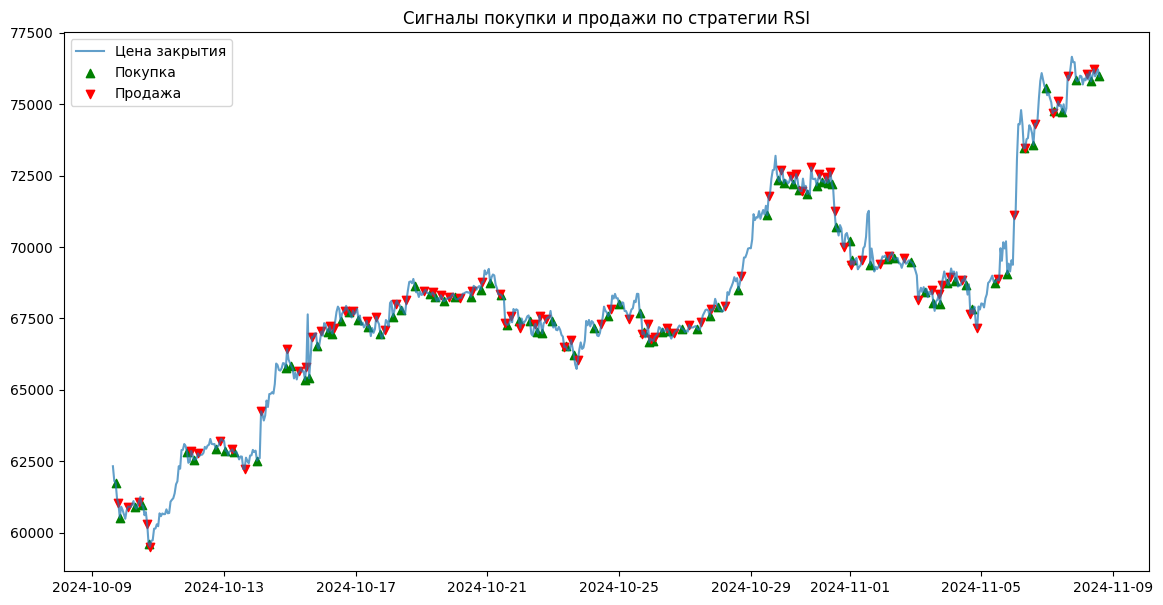

In [8]:
import talib as ta
import pandas as pd
import numpy as np

# Параметры стратегии
RSI_PERIOD = 2
RSI_BUY_LEVEL = 33
RSI_SELL_LEVEL = 68
STOP_LOSS_RATIO = 0.01  # Стоп-лосс 0.45%
TAKE_PROFIT_RATIO = 0.03  # Тейк-профит 3%

# Загрузка данных (параметры можно настроить по своему усмотрению)
data = get_data('kraken', '2024-04-01T00:00:00Z', '2024-05-31T00:00:00Z', '1h', 'BTC/USDT')
data.reset_index(inplace=True)

# Рассчитываем RSI
data['RSI'] = ta.RSI(data['close'], timeperiod=RSI_PERIOD)

# Создаем столбцы для сигналов и результатов
data['signal'] = 0  # 1 — покупка, -1 — продажа, 0 — нет сигнала
data['price_entry'] = np.nan  # Цена входа в сделку
data['price_exit'] = np.nan  # Цена выхода
data['trade_result'] = np.nan  # Результат сделки в процентах

# Статусы для управления сделками
in_position = False
entry_price = 0

# Логика стратегии
for i in range(1, len(data)):
    if not in_position:  # Если мы не в позиции
        if data['RSI'][i] < RSI_BUY_LEVEL:  # Условие для покупки
            entry_price = data['close'][i]
            stop_loss = entry_price * (1 - STOP_LOSS_RATIO)
            take_profit = entry_price * (1 + TAKE_PROFIT_RATIO)
            data.at[i, 'signal'] = 1  # Сигнал на покупку
            data.at[i, 'price_entry'] = entry_price
            in_position = True
    else:  # Если мы в позиции
        # Проверяем, достигли ли стоп-лосса или тейк-профита
        if data['low'][i] <= stop_loss:  # Стоп-лосс
            exit_price = stop_loss
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = exit_price
            data.at[i, 'trade_result'] = (exit_price - entry_price) / entry_price * 100
            in_position = False
        elif data['high'][i] >= take_profit:  # Тейк-профит
            exit_price = take_profit
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = exit_price
            data.at[i, 'trade_result'] = (exit_price - entry_price) / entry_price * 100
            in_position = False
        elif data['RSI'][i] > RSI_SELL_LEVEL:  # Продаем по RSI
            exit_price = data['close'][i]
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = exit_price
            data.at[i, 'trade_result'] = (exit_price - entry_price) / entry_price * 100
            in_position = False

# Выводим результаты сделок
trades = data.dropna(subset=['trade_result'])
print(f"Всего сделок: {len(trades)}")
print(f"Успешные сделки: {len(trades[trades['trade_result'] > 0])}")
print(f"Процент успешных сделок: {len(trades[trades['trade_result'] > 0]) / len(trades) * 100:.2f}%")
print(f"Общая доходность: {trades['trade_result'].sum():.2f}%")
print(f"Максимальная прибыль: {trades['trade_result'].max():.2f}%")
print(f"Максимальный убыток: {trades['trade_result'].min():.2f}%")

# Средняя и медианная доходность и убыток
average_profit = trades[trades['trade_result'] > 0]['trade_result'].mean()
median_profit = trades[trades['trade_result'] > 0]['trade_result'].median()
average_loss = trades[trades['trade_result'] < 0]['trade_result'].mean()
median_loss = trades[trades['trade_result'] < 0]['trade_result'].median()

print(f"Средняя доходность: {average_profit:.2f}%")
print(f"Медианная доходность: {median_profit:.2f}%")
print(f"Средний убыток: {average_loss:.2f}%")
print(f"Медианный убыток: {median_loss:.2f}%")

# Доходность рынка за период
market_return = (data['close'].iloc[-1] - data['close'].iloc[0]) / data['close'].iloc[0] * 100
strategy_return = trades['trade_result'].sum()

print(f"Доходность рынка за период: {market_return:.2f}%")
print(f"Доходность стратегии за период: {strategy_return:.2f}%")

# Визуализация
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(data['date'], data['close'], label='Цена закрытия', alpha=0.7)
buy_signals = data[data['signal'] == 1]
sell_signals = data[data['signal'] == -1]
plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='green', label='Покупка', alpha=1)
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='red', label='Продажа', alpha=1)
plt.title('Сигналы покупки и продажи по стратегии RSI')
plt.legend()
plt.show()

Всего сделок: 91
Успешные сделки: 63
Процент успешных сделок: 69.23%
Общая доходность: 12.76%
Максимальная прибыль: 2.97%
Максимальный убыток: -1.89%
Средняя доходность: 0.52%
Медианная доходность: 0.38%
Средний убыток: -0.72%
Медианный убыток: -0.83%
Доходность рынка за период: 21.91%
Доходность стратегии за период: 12.76%


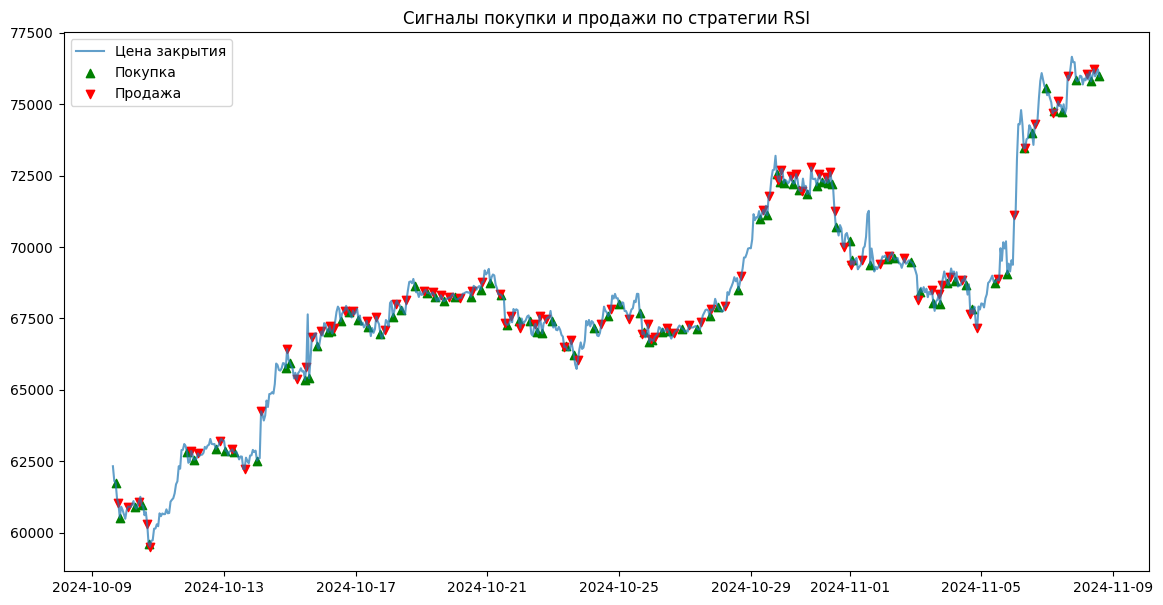

In [9]:
import talib as ta
import pandas as pd
import numpy as np

# Параметры стратегии
RSI_PERIOD = 2
RSI_BUY_LEVEL = 36
RSI_SELL_LEVEL = 68
STOP_LOSS_RATIO = 0.01  # Стоп-лосс 0.45%
TAKE_PROFIT_RATIO = 0.03  # Тейк-профит 3%
EXIT_DELAY = 0  # Задержка выхода из позиции на N баров

# Загрузка данных
data = get_data('kraken', '2024-04-01T00:00:00Z', '2024-05-31T00:00:00Z', '1h', 'BTC/USDT')
data.reset_index(inplace=True)

# Рассчитываем RSI
data['RSI'] = ta.RSI(data['close'], timeperiod=RSI_PERIOD)

# Создаем столбцы для сигналов и результатов
data['signal'] = 0
data['price_entry'] = np.nan
data['price_exit'] = np.nan
data['trade_result'] = np.nan

# Статусы для управления сделками
in_position = False
entry_price = 0
exit_signal = None
exit_price = 0
exit_bar = 0

# Логика стратегии
for i in range(1, len(data)):
    if not in_position:
        if data['RSI'][i] < RSI_BUY_LEVEL:
            entry_price = data['close'][i]
            stop_loss = entry_price * (1 - STOP_LOSS_RATIO)
            take_profit = entry_price * (1 + TAKE_PROFIT_RATIO)
            data.at[i, 'signal'] = 1
            data.at[i, 'price_entry'] = entry_price
            in_position = True
    else:
        if exit_signal is None:
            if data['low'][i] <= stop_loss:
                exit_signal = 'stop_loss'
                exit_price = stop_loss
                exit_bar = i + EXIT_DELAY
            elif data['high'][i] >= take_profit:
                exit_signal = 'take_profit'
                exit_price = take_profit
                exit_bar = i + EXIT_DELAY
            elif data['RSI'][i] > RSI_SELL_LEVEL:
                exit_signal = 'RSI'
                exit_price = data['close'][i]
                exit_bar = i + EXIT_DELAY

        if exit_signal is not None and i >= exit_bar:
            data.at[i, 'signal'] = -1
            data.at[i, 'price_exit'] = data['close'][i]
            data.at[i, 'trade_result'] = (data['close'][i] - entry_price) / entry_price * 100
            in_position = False
            exit_signal = None

# Выводим результаты сделок
trades = data.dropna(subset=['trade_result'])
print(f"Всего сделок: {len(trades)}")
print(f"Успешные сделки: {len(trades[trades['trade_result'] > 0])}")
print(f"Процент успешных сделок: {len(trades[trades['trade_result'] > 0]) / len(trades) * 100:.2f}%")
print(f"Общая доходность: {trades['trade_result'].sum():.2f}%")
print(f"Максимальная прибыль: {trades['trade_result'].max():.2f}%")
print(f"Максимальный убыток: {trades['trade_result'].min():.2f}%")

# Средняя и медианная доходность и убыток
average_profit = trades[trades['trade_result'] > 0]['trade_result'].mean()
median_profit = trades[trades['trade_result'] > 0]['trade_result'].median()
average_loss = trades[trades['trade_result'] < 0]['trade_result'].mean()
median_loss = trades[trades['trade_result'] < 0]['trade_result'].median()

print(f"Средняя доходность: {average_profit:.2f}%")
print(f"Медианная доходность: {median_profit:.2f}%")
print(f"Средний убыток: {average_loss:.2f}%")
print(f"Медианный убыток: {median_loss:.2f}%")

# Доходность рынка за период
market_return = (data['close'].iloc[-1] - data['close'].iloc[0]) / data['close'].iloc[0] * 100
strategy_return = trades['trade_result'].sum()

print(f"Доходность рынка за период: {market_return:.2f}%")
print(f"Доходность стратегии за период: {strategy_return:.2f}%")

# Визуализация
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 7))
plt.plot(data['date'], data['close'], label='Цена закрытия', alpha=0.7)
buy_signals = data[data['signal'] == 1]
sell_signals = data[data['signal'] == -1]
plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='green', label='Покупка', alpha=1)
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='red', label='Продажа', alpha=1)
plt.title('Сигналы покупки и продажи по стратегии RSI')
plt.legend()
plt.show()

Всего сделок: 68
Успешные сделки: 43
Процент успешных сделок: 63.24%
Общая доходность: 16.49%
Максимальная прибыль: 2.97%
Максимальный убыток: -1.47%


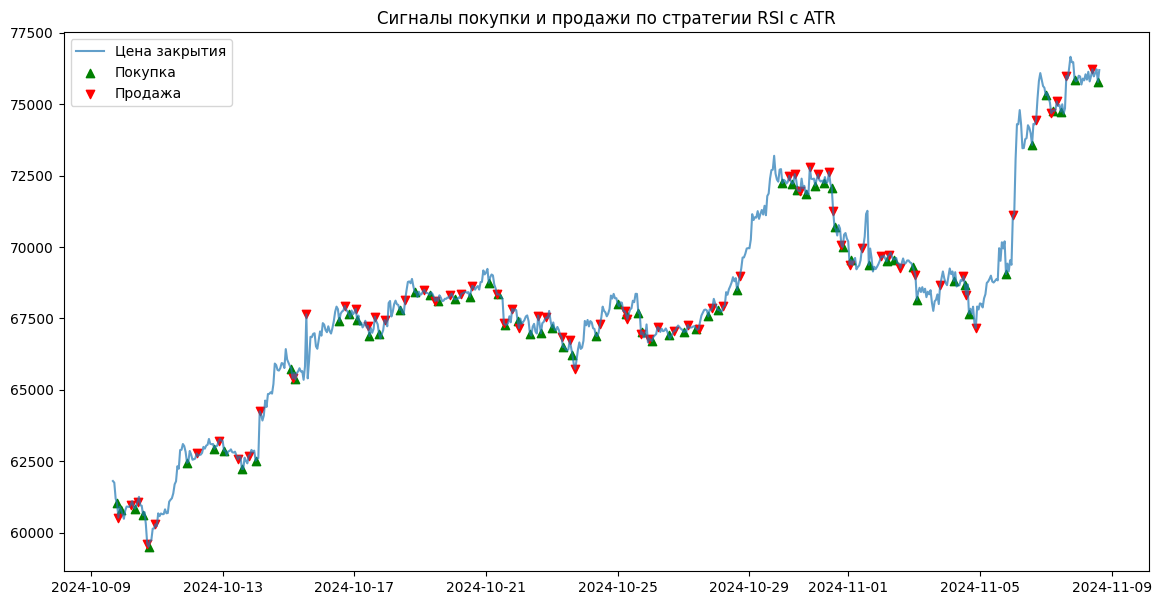

In [44]:
#@title RSI 3 + ATR // buy 35 sell 65 (Чистые сигналы)
import talib as ta
import pandas as pd
import numpy as np

# Параметры стратегии
RSI_PERIOD = 3
RSI_BUY_LEVEL = 35
RSI_SELL_LEVEL = 69
ATR_PERIOD = 3  # Период ATR для расчета волатильности
ATR_MULTIPLIER_SL = 1 # Множитель для стоп-лосса
ATR_MULTIPLIER_TP = 4  # Множитель для тейк-профита

# Загрузка данных (параметры можно настроить по своему усмотрению)
data = get_data('kraken', '2024-04-01T00:00:00Z', '2024-05-31T00:00:00Z', '1h', 'BTC/USDT')
data.reset_index(inplace=True)

# Рассчитываем RSI
data['RSI'] = ta.RSI(data['close'], timeperiod=RSI_PERIOD)

# Рассчитываем ATR для динамических стоп-лоссов и тейк-профитов
data['ATR'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=ATR_PERIOD)

# Создаем столбцы для сигналов и результатов
data['signal'] = 0  # 1 — покупка, -1 — продажа, 0 — нет сигнала
data['price_entry'] = np.nan  # Цена входа в сделку
data['price_exit'] = np.nan  # Цена выхода
data['trade_result'] = np.nan  # Результат сделки в процентах

# Статусы для управления сделками
in_position = False
entry_price = 0

# Логика стратегии
for i in range(1, len(data)):
    if not in_position:  # Если мы не в позиции
        if data['RSI'][i] < RSI_BUY_LEVEL:  # Условие для покупки
            entry_price = data['close'][i]
            atr_value = data['ATR'][i]  # Текущее значение ATR
            stop_loss = entry_price - ATR_MULTIPLIER_SL * atr_value  # Стоп-лосс на основе ATR
            take_profit = entry_price + ATR_MULTIPLIER_TP * atr_value  # Тейк-профит на основе ATR
            data.at[i, 'signal'] = 1  # Сигнал на покупку
            data.at[i, 'price_entry'] = entry_price
            in_position = True
    else:  # Если мы в позиции
        # Проверяем, достигли ли стоп-лосса или тейк-профита
        if data['low'][i] <= stop_loss:  # Стоп-лосс
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = stop_loss
            data.at[i, 'trade_result'] = (stop_loss - entry_price) / entry_price * 100
            in_position = False
        elif data['high'][i] >= take_profit:  # Тейк-профит
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = take_profit
            data.at[i, 'trade_result'] = (take_profit - entry_price) / entry_price * 100
            in_position = False
        elif data['RSI'][i] > RSI_SELL_LEVEL:  # Продаем по RSI
            exit_price = data['close'][i]
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = exit_price
            data.at[i, 'trade_result'] = (exit_price - entry_price) / entry_price * 100
            in_position = False

# Выводим результаты сделок
trades = data.dropna(subset=['trade_result'])
print(f"Всего сделок: {len(trades)}")
print(f"Успешные сделки: {len(trades[trades['trade_result'] > 0])}")
print(f"Процент успешных сделок: {len(trades[trades['trade_result'] > 0]) / len(trades) * 100:.2f}%")
print(f"Общая доходность: {trades['trade_result'].sum():.2f}%")
print(f"Максимальная прибыль: {trades['trade_result'].max():.2f}%")
print(f"Максимальный убыток: {trades['trade_result'].min():.2f}%")

# Визуализация
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(data['date'], data['close'], label='Цена закрытия', alpha=0.7)
buy_signals = data[data['signal'] == 1]
sell_signals = data[data['signal'] == -1]
plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='green', label='Покупка', alpha=1)
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='red', label='Продажа', alpha=1)
plt.title('Сигналы покупки и продажи по стратегии RSI с ATR')
plt.legend()
plt.show()

Всего сделок: 73
Успешные сделки: 55
Процент успешных сделок: 75.34%
Общая доходность: 15.90%
Максимальная прибыль: 2.97%
Максимальный убыток: -2.18%


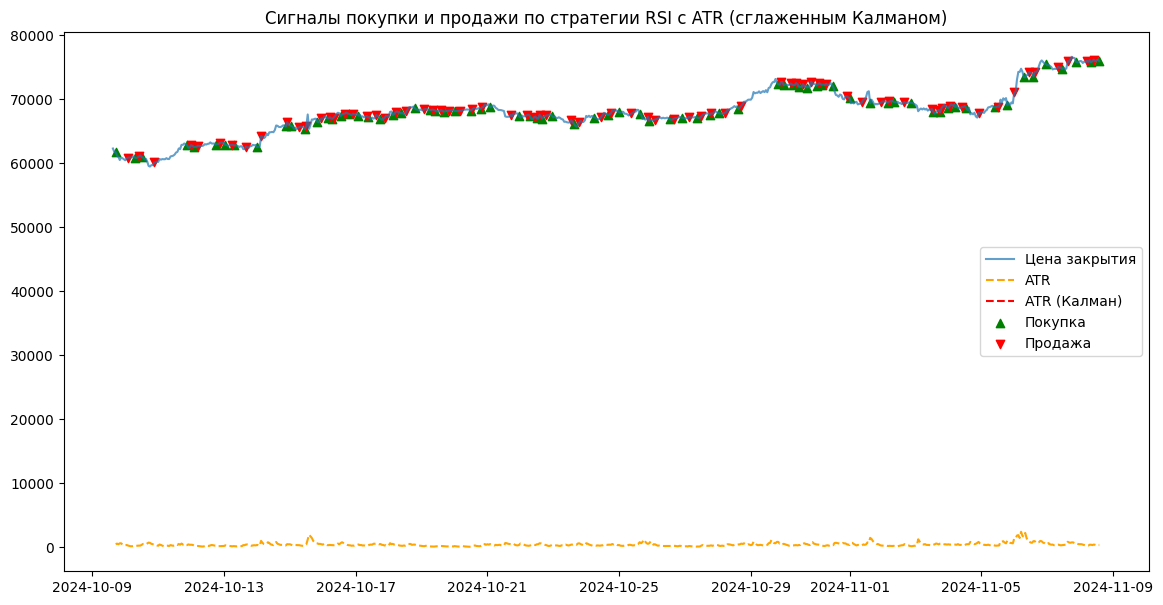

In [11]:
import talib as ta
import pandas as pd
import numpy as np
from pykalman import KalmanFilter

# Параметры стратегии
RSI_PERIOD = 2
RSI_BUY_LEVEL = 31
RSI_SELL_LEVEL = 69
ATR_PERIOD = 2  # Период ATR для расчета волатильности
ATR_MULTIPLIER_SL = 1  # Множитель для стоп-лосса
ATR_MULTIPLIER_TP = 3  # Множитель для тейк-профита

# Функция для применения фильтра Калмана
def apply_kalman_filter(data):
    kf = KalmanFilter(transition_matrices=[1],
                      observation_matrices=[1],
                      initial_state_mean=0,
                      initial_state_covariance=1,
                      observation_covariance=1,
                      transition_covariance=0.01)
    state_means, _ = kf.filter(data)
    return state_means.flatten()

# Загрузка данных (параметры можно настроить по своему усмотрению)
data = get_data('kraken', '2024-04-01T00:00:00Z', '2024-05-31T00:00:00Z', '1h', 'BTC/USDT')
data.reset_index(inplace=True)

# Рассчитываем стандартный RSI
data['RSI'] = ta.RSI(data['close'], timeperiod=RSI_PERIOD)

# Рассчитываем стандартный ATR
data['ATR'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=ATR_PERIOD)

# Применяем фильтр Калмана к значениям ATR
data['ATR_kalman'] = apply_kalman_filter(data['ATR'].values)

# Создаем столбцы для сигналов и результатов
data['signal'] = 0  # 1 — покупка, -1 — продажа, 0 — нет сигнала
data['price_entry'] = np.nan  # Цена входа в сделку
data['price_exit'] = np.nan  # Цена выхода
data['trade_result'] = np.nan  # Результат сделки в процентах

# Статусы для управления сделками
in_position = False
entry_price = 0

# Логика стратегии
for i in range(1, len(data)):
    if not in_position:  # Если мы не в позиции
        # Условие для покупки: RSI ниже уровня покупки
        if data['RSI'][i] < RSI_BUY_LEVEL:
            entry_price = data['close'][i]
            atr_value = data['ATR_kalman'][i]  # Сглаженное значение ATR
            stop_loss = entry_price - ATR_MULTIPLIER_SL * atr_value  # Стоп-лосс на основе сглаженного ATR
            take_profit = entry_price + ATR_MULTIPLIER_TP * atr_value  # Тейк-профит на основе сглаженного ATR
            data.at[i, 'signal'] = 1  # Сигнал на покупку
            data.at[i, 'price_entry'] = entry_price
            in_position = True
    else:  # Если мы в позиции
        # Проверяем, достигли ли стоп-лосса или тейк-профита
        if data['low'][i] <= stop_loss:  # Стоп-лосс
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = stop_loss
            data.at[i, 'trade_result'] = (stop_loss - entry_price) / entry_price * 100
            in_position = False
        elif data['high'][i] >= take_profit:  # Тейк-профит
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = take_profit
            data.at[i, 'trade_result'] = (take_profit - entry_price) / entry_price * 100
            in_position = False
        # Продаем по RSI
        elif data['RSI'][i] > RSI_SELL_LEVEL:
            exit_price = data['close'][i]
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = exit_price
            data.at[i, 'trade_result'] = (exit_price - entry_price) / entry_price * 100
            in_position = False

# Выводим результаты сделок
trades = data.dropna(subset=['trade_result'])
print(f"Всего сделок: {len(trades)}")
print(f"Успешные сделки: {len(trades[trades['trade_result'] > 0])}")
print(f"Процент успешных сделок: {len(trades[trades['trade_result'] > 0]) / len(trades) * 100:.2f}%")
print(f"Общая доходность: {trades['trade_result'].sum():.2f}%")
print(f"Максимальная прибыль: {trades['trade_result'].max():.2f}%")
print(f"Максимальный убыток: {trades['trade_result'].min():.2f}%")

# Визуализация
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(data['date'], data['close'], label='Цена закрытия', alpha=0.7)
plt.plot(data['date'], data['ATR'], label='ATR', linestyle='--', color='orange')
plt.plot(data['date'], data['ATR_kalman'], label='ATR (Калман)', linestyle='--', color='red')
buy_signals = data[data['signal'] == 1]
sell_signals = data[data['signal'] == -1]
plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='green', label='Покупка', alpha=1)
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='red', label='Продажа', alpha=1)
plt.title('Сигналы покупки и продажи по стратегии RSI с ATR (сглаженным Калманом)')
plt.legend()
plt.show()

Всего сделок: 15
Успешные сделки: 11
Процент успешных сделок: 73.33%
Общая доходность: 4.59%
Максимальная прибыль: 2.96%
Максимальный убыток: -2.23%


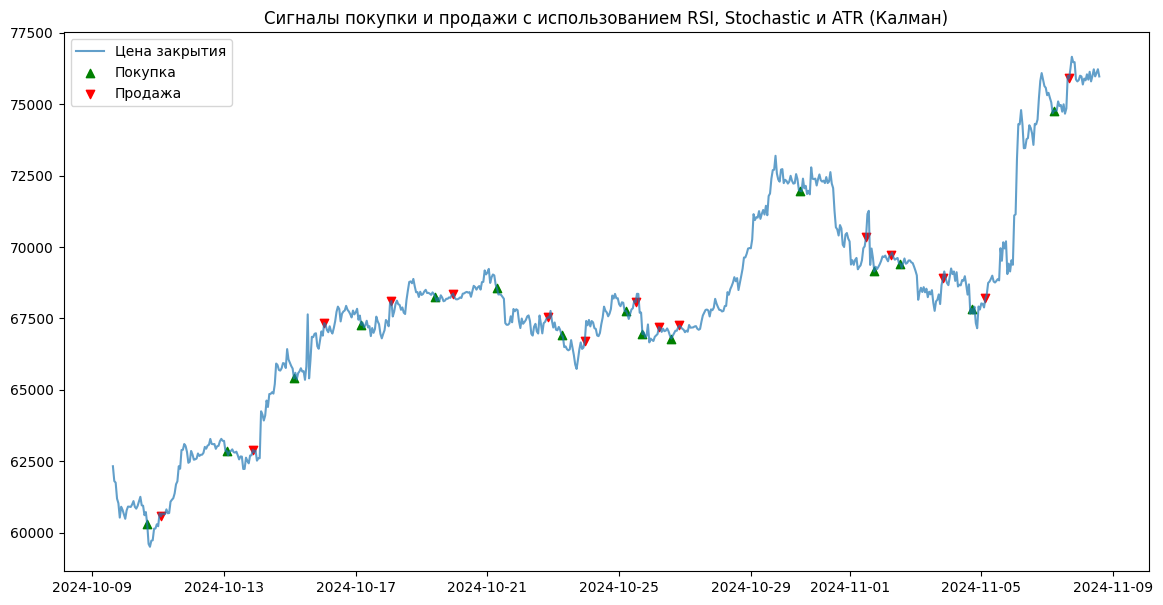

In [13]:
#@title RSI 2 + Stochastic + ATR Kalman (ATR не работает вместе с Кальманом везде) // buy 35 sell 65
import talib as ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter

# Параметры стратегии
RSI_PERIOD = 2 # Эта комбинация хорощо работала на нейтральном рынке, с ATR комбинируется плохо
RSI_BUY_LEVEL = 35
RSI_SELL_LEVEL = 66
STOCH_K_PERIOD = 10  # Период для K линии стохастика
STOCH_D_PERIOD = 2   # Период для D линии стохастика
STOCH_OVERBOUGHT = 75
STOCH_OVERSOLD = 25
ATR_PERIOD = 2  # Период ATR для расчета волатильности
ATR_MULTIPLIER_SL = 1  # Множитель для стоп-лосса
ATR_MULTIPLIER_TP = 2.5  # Множитель для тейк-профита

# Функция для применения фильтра Калмана
def apply_kalman_filter(data):
    kf = KalmanFilter(transition_matrices=[1],
                      observation_matrices=[1],
                      initial_state_mean=0,
                      initial_state_covariance=1,
                      observation_covariance=1,
                      transition_covariance=0.01)
    state_means, _ = kf.filter(data)
    return state_means.flatten()

# Загрузка данных
data = get_data('kraken', '2024-04-01T00:00:00Z', '2024-05-31T00:00:00Z', '1h', 'BTC/USDT')
data.reset_index(inplace=True)

# Рассчитываем RSI
data['RSI'] = ta.RSI(data['close'], timeperiod=RSI_PERIOD)

# Рассчитываем стохастик
data['STOCH_K'], data['STOCH_D'] = ta.STOCH(data['high'], data['low'], data['close'],
                                             fastk_period=STOCH_K_PERIOD,
                                             slowk_period=STOCH_D_PERIOD,
                                             slowk_matype=0,
                                             slowd_period=STOCH_D_PERIOD,
                                             slowd_matype=0)

# Рассчитываем стандартный ATR
data['ATR'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=ATR_PERIOD)

# Применяем фильтр Калмана к значениям ATR
data['ATR_Kalman'] = apply_kalman_filter(data['ATR'])

# Создаем столбцы для сигналов и результатов
data['signal'] = 0  # 1 — покупка, -1 — продажа, 0 — нет сигнала
data['price_entry'] = np.nan  # Цена входа в сделку
data['price_exit'] = np.nan  # Цена выхода
data['trade_result'] = np.nan  # Результат сделки в процентах

# Статусы для управления сделками
in_position = False
entry_price = 0

# Логика стратегии
for i in range(1, len(data)):
    if not in_position:  # Если мы не в позиции
        # Условие для покупки: RSI ниже уровня покупки и стохастик показывает перепроданность
        if data['RSI'][i] < RSI_BUY_LEVEL and data['STOCH_K'][i] < STOCH_OVERSOLD and data['STOCH_D'][i] < STOCH_OVERSOLD:
            entry_price = data['close'][i]
            atr_value = data['ATR_Kalman'][i]  # Используем сглаженный ATR с фильтром Калмана
            stop_loss = entry_price - ATR_MULTIPLIER_SL * atr_value  # Стоп-лосс на основе сглаженного ATR
            take_profit = entry_price + ATR_MULTIPLIER_TP * atr_value  # Тейк-профит на основе сглаженного ATR
            data.at[i, 'signal'] = 1  # Сигнал на покупку
            data.at[i, 'price_entry'] = entry_price
            in_position = True
    else:  # Если мы в позиции
        # Проверяем, достигли ли стоп-лосса или тейк-профита
        if data['low'][i] <= stop_loss:  # Стоп-лосс
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = stop_loss
            data.at[i, 'trade_result'] = (stop_loss - entry_price) / entry_price * 100
            in_position = False
        elif data['high'][i] >= take_profit:  # Тейк-профит
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = take_profit
            data.at[i, 'trade_result'] = (take_profit - entry_price) / entry_price * 100
            in_position = False
        # Продаем, если RSI выше уровня продажи и стохастик показывает перекупленность
        elif data['RSI'][i] > RSI_SELL_LEVEL and data['STOCH_K'][i] > STOCH_OVERBOUGHT and data['STOCH_D'][i] > STOCH_OVERBOUGHT:
            exit_price = data['close'][i]
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = exit_price
            data.at[i, 'trade_result'] = (exit_price - entry_price) / entry_price * 100
            in_position = False

# Выводим результаты сделок
trades = data.dropna(subset=['trade_result'])
print(f"Всего сделок: {len(trades)}")
print(f"Успешные сделки: {len(trades[trades['trade_result'] > 0])}")
print(f"Процент успешных сделок: {len(trades[trades['trade_result'] > 0]) / len(trades) * 100:.2f}%")
print(f"Общая доходность: {trades['trade_result'].sum():.2f}%")
print(f"Максимальная прибыль: {trades['trade_result'].max():.2f}%")
print(f"Максимальный убыток: {trades['trade_result'].min():.2f}%")

# Визуализация
plt.figure(figsize=(14, 7))

# График цены закрытия
plt.plot(data['date'], data['close'], label='Цена закрытия', alpha=0.7)
buy_signals = data[data['signal'] == 1]
sell_signals = data[data['signal'] == -1]
plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='green', label='Покупка', alpha=1)
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='red', label='Продажа', alpha=1)
plt.title('Сигналы покупки и продажи с использованием RSI, Stochastic и ATR (Калман)')
plt.legend()

plt.show()

Всего сделок: 54
Успешные сделки: 42
Процент успешных сделок: 77.78%
Текущий капитал: 12017.28 USD
Общая доходность: 20.17%
Максимальная прибыль: 2.97%
Максимальный убыток: -3.14%


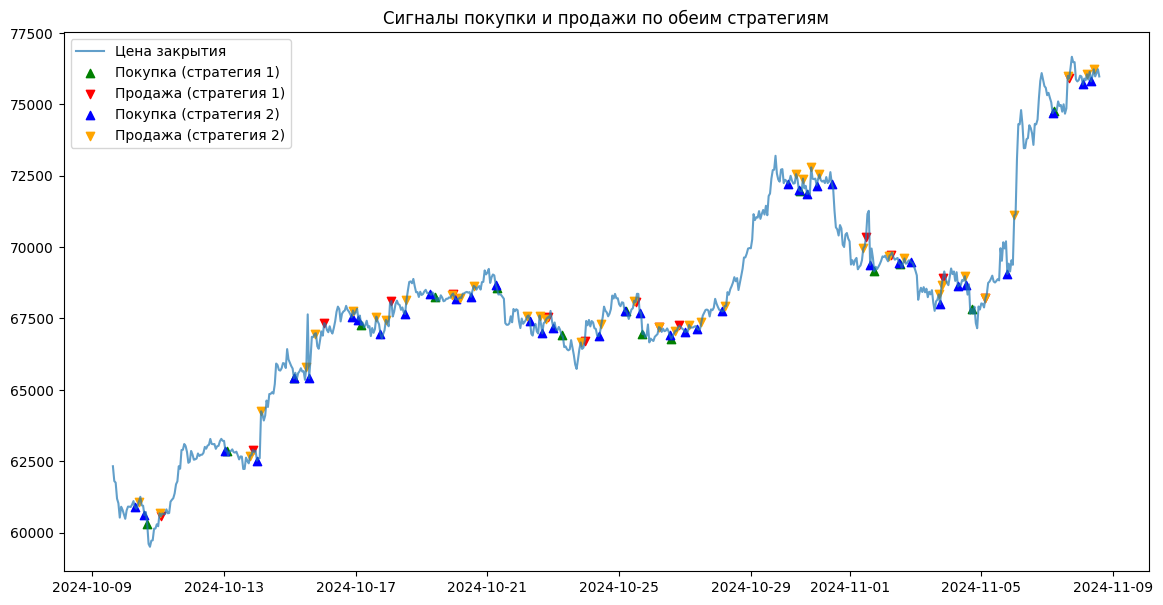

In [14]:
#@title 2 Both Strategy # Обе стратегии плохо работают на растущем рынке
import talib as ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter

# Параметры стратегии
RSI_PERIOD_1 = 2
RSI_BUY_LEVEL_1 = 35
RSI_SELL_LEVEL_1 = 66

STOCH_K_PERIOD = 10  # Период для K линии стохастика
STOCH_D_PERIOD = 2   # Период для D линии стохастика
STOCH_OVERBOUGHT = 75
STOCH_OVERSOLD = 25

# Параметры второй стратегии
RSI_PERIOD_2 = 2
RSI_BUY_LEVEL_2 = 32
RSI_SELL_LEVEL_2 = 71

BBANDS_PERIOD = 16  # Период для расчета полос Боллинджера
BBANDS_STDDEV = 0.1  # Стандартное отклонение для полос Боллинджера

# Общие параметры для обеих стратегий
ATR_PERIOD = 2  # Период ATR для расчета волатильности
ATR_MULTIPLIER_SL = 0.6  # Множитель для стоп-лосса
ATR_MULTIPLIER_TP = 2.5  # Множитель для тейк-профита

# Функция для применения фильтра Калмана
def apply_kalman_filter(data):
    kf = KalmanFilter(transition_matrices=[1],
                      observation_matrices=[1],
                      initial_state_mean=0,
                      initial_state_covariance=1,
                      observation_covariance=1,
                      transition_covariance=0.01)
    state_means, _ = kf.filter(data)
    return state_means.flatten()

# Загрузка данных
data = get_data('kraken', '2024-04-01T00:00:00Z', '2024-05-31T00:00:00Z', '1h', 'BTC/USDT')
data.reset_index(inplace=True)

# Рассчитываем RSI для 1-й стратегии
data['RSI_1'] = ta.RSI(data['close'], timeperiod=RSI_PERIOD_1)

# Рассчитываем стохастик для 1-й стратегии
data['STOCH_K_1'], data['STOCH_D_1'] = ta.STOCH(data['high'], data['low'], data['close'],
                                                 fastk_period=STOCH_K_PERIOD,
                                                 slowk_period=STOCH_D_PERIOD,
                                                 slowk_matype=0,
                                                 slowd_period=STOCH_D_PERIOD,
                                                 slowd_matype=0)

# Рассчитываем RSI для 2-й стратегии
data['RSI_2'] = ta.RSI(data['close'], timeperiod=RSI_PERIOD_2)

# Рассчитываем полосы Боллинджера для 2-й стратегии
data['BB_upper'], data['BB_middle'], data['BB_lower'] = ta.BBANDS(data['close'], timeperiod=BBANDS_PERIOD, nbdevup=BBANDS_STDDEV, nbdevdn=BBANDS_STDDEV, matype=0)

# Рассчитываем стандартный ATR
data['ATR'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=ATR_PERIOD)

# Применяем фильтр Калмана к значениям ATR
data['ATR_Kalman'] = apply_kalman_filter(data['ATR'])

# Создаем столбцы для сигналов и результатов
data['signal_1'] = 0  # 1-я стратегия: покупка = 1, продажа = -1
data['signal_2'] = 0  # 2-я стратегия: покупка = 1, продажа = -1
data['price_entry_1'] = np.nan  # Цена входа для 1-й стратегии
data['price_entry_2'] = np.nan  # Цена входа для 2-й стратегии
data['price_exit_1'] = np.nan   # Цена выхода для 1-й стратегии
data['price_exit_2'] = np.nan   # Цена выхода для 2-й стратегии
data['trade_result_1'] = np.nan  # Результат сделки для 1-й стратегии
data['trade_result_2'] = np.nan  # Результат сделки для 2-й стратегии

# Статусы для управления сделками
in_position_1 = False
in_position_2 = False
entry_price_1 = 0
entry_price_2 = 0
stop_loss = np.nan  # Общий стоп-лосс для обеих стратегий
take_profit = np.nan  # Общий тейк-профит для обеих стратегий

# Начальный капитал
initial_capital = 10000  # 10,000 USD
current_capital = initial_capital

# Логика для 1-й стратегии
for i in range(1, len(data)):
    if not in_position_1:  # Если мы не в позиции по 1-й стратегии
        # Условие для покупки: RSI ниже уровня покупки и стохастик показывает перепроданность
        if data['RSI_1'][i] < RSI_BUY_LEVEL_1 and data['STOCH_K_1'][i] < STOCH_OVERSOLD and data['STOCH_D_1'][i] < STOCH_OVERSOLD:
            entry_price_1 = data['close'][i]
            atr_value = data['ATR_Kalman'][i]  # Используем сглаженный ATR с фильтром Калмана
            stop_loss = entry_price_1 - ATR_MULTIPLIER_SL * atr_value  # Общий стоп-лосс
            take_profit = entry_price_1 + ATR_MULTIPLIER_TP * atr_value  # Общий тейк-профит
            data.at[i, 'signal_1'] = 1  # Сигнал на покупку
            data.at[i, 'price_entry_1'] = entry_price_1
            in_position_1 = True
    else:  # Если мы в позиции по 1-й стратегии
        # Проверяем, достигли ли стоп-лосса или тейк-профита
        if data['low'][i] <= stop_loss:  # Стоп-лосс
            data.at[i, 'signal_1'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit_1'] = stop_loss
            trade_return = (stop_loss - entry_price_1) / entry_price_1 * 100
            data.at[i, 'trade_result_1'] = trade_return
            current_capital *= (1 + trade_return / 100)  # Обновляем капитал
            in_position_1 = False
        elif data['high'][i] >= take_profit:  # Тейк-профит
            data.at[i, 'signal_1'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit_1'] = take_profit
            trade_return = (take_profit - entry_price_1) / entry_price_1 * 100
            data.at[i, 'trade_result_1'] = trade_return
            current_capital *= (1 + trade_return / 100)  # Обновляем капитал
            in_position_1 = False
        # Продаем по RSI
        elif data['RSI_1'][i] > RSI_SELL_LEVEL_1 and data['STOCH_K_1'][i] > STOCH_OVERBOUGHT and data['STOCH_D_1'][i] > STOCH_OVERBOUGHT:
            exit_price_1 = data['close'][i]
            data.at[i, 'signal_1'] = -1  # Сигнал на продажу
            trade_return = (exit_price_1 - entry_price_1) / entry_price_1 * 100
            data.at[i, 'price_exit_1'] = exit_price_1
            data.at[i, 'trade_result_1'] = trade_return
            current_capital *= (1 + trade_return / 100)  # Обновляем капитал
            in_position_1 = False

# Логика для 2-й стратегии
    if not in_position_2:  # Если мы не в позиции по 2-й стратегии
        # Условие для покупки: RSI ниже уровня покупки и цена касается нижней полосы Боллинджера
        if data['RSI_2'][i] < RSI_BUY_LEVEL_2 and data['close'][i] <= data['BB_lower'][i]:
            entry_price_2 = data['close'][i]
            atr_value = data['ATR_Kalman'][i]  # Используем сглаженный ATR с фильтром Калмана
            stop_loss = entry_price_2 - ATR_MULTIPLIER_SL * atr_value  # Общий стоп-лосс
            take_profit = entry_price_2 + ATR_MULTIPLIER_TP * atr_value  # Общий тейк-профит
            data.at[i, 'signal_2'] = 1  # Сигнал на покупку
            data.at[i, 'price_entry_2'] = entry_price_2
            in_position_2 = True
    else:  # Если мы в позиции по 2-й стратегии
        # Проверяем, достигли ли стоп-лосса или тейк-профита
        if data['low'][i] <= stop_loss:  # Стоп-лосс
            data.at[i, 'signal_2'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit_2'] = stop_loss
            trade_return = (stop_loss - entry_price_2) / entry_price_2 * 100
            data.at[i, 'trade_result_2'] = trade_return
            current_capital *= (1 + trade_return / 100)  # Обновляем капитал
            in_position_2 = False
        elif data['high'][i] >= take_profit:  # Тейк-профит
            data.at[i, 'signal_2'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit_2'] = take_profit
            trade_return = (take_profit - entry_price_2) / entry_price_2 * 100
            data.at[i, 'trade_result_2'] = trade_return
            current_capital *= (1 + trade_return / 100)  # Обновляем капитал
            in_position_2 = False
        # Продаем по RSI, если цена касается верхней полосы Боллинджера
        elif data['RSI_2'][i] > RSI_SELL_LEVEL_2 and data['close'][i] >= data['BB_upper'][i]:
            exit_price_2 = data['close'][i]
            data.at[i, 'signal_2'] = -1  # Сигнал на продажу
            trade_return = (exit_price_2 - entry_price_2) / entry_price_2 * 100
            data.at[i, 'price_exit_2'] = exit_price_2
            data.at[i, 'trade_result_2'] = trade_return
            current_capital *= (1 + trade_return / 100)  # Обновляем капитал
            in_position_2 = False

# Выводим результаты сделок для обеих стратегий
trades_1 = data.dropna(subset=['trade_result_1'])
trades_2 = data.dropna(subset=['trade_result_2'])

# Общие результаты по обеим стратегиям
total_trades = len(trades_1) + len(trades_2)
successful_trades = len(trades_1[trades_1['trade_result_1'] > 0]) + len(trades_2[trades_2['trade_result_2'] > 0])
total_return = trades_1['trade_result_1'].sum() + trades_2['trade_result_2'].sum()
max_profit = max(trades_1['trade_result_1'].max(), trades_2['trade_result_2'].max())
max_loss = min(trades_1['trade_result_1'].min(), trades_2['trade_result_2'].min())

# Выводим общие результаты
print(f"Всего сделок: {total_trades}")
print(f"Успешные сделки: {successful_trades}")
print(f"Процент успешных сделок: {successful_trades / total_trades * 100:.2f}%")
print(f"Текущий капитал: {current_capital:.2f} USD")
print(f"Общая доходность: {(current_capital - initial_capital) / initial_capital * 100:.2f}%")
print(f"Максимальная прибыль: {max_profit:.2f}%")
print(f"Максимальный убыток: {max_loss:.2f}%")

# Визуализация
plt.figure(figsize=(14, 7))

# График цены закрытия
plt.plot(data['date'], data['close'], label='Цена закрытия', alpha=0.7)

# Сигналы по первой стратегии
buy_signals_1 = data[data['signal_1'] == 1]
sell_signals_1 = data[data['signal_1'] == -1]
plt.scatter(buy_signals_1['date'], buy_signals_1['close'], marker='^', color='green', label='Покупка (стратегия 1)', alpha=1)
plt.scatter(sell_signals_1['date'], sell_signals_1['close'], marker='v', color='red', label='Продажа (стратегия 1)', alpha=1)

# Сигналы по второй стратегии
buy_signals_2 = data[data['signal_2'] == 1]
sell_signals_2 = data[data['signal_2'] == -1]
plt.scatter(buy_signals_2['date'], buy_signals_2['close'], marker='^', color='blue', label='Покупка (стратегия 2)', alpha=1)
plt.scatter(sell_signals_2['date'], sell_signals_2['close'], marker='v', color='orange', label='Продажа (стратегия 2)', alpha=1)

plt.title('Сигналы покупки и продажи по обеим стратегиям')
plt.legend()

plt.show()

Всего сделок: 22
Успешные сделки: 10
Процент успешных сделок: 45.45%
Текущий капитал: 11615.72 USD
Общая доходность: 16.16%
Максимальная прибыль: 4.00%
Максимальный убыток: -2.00%


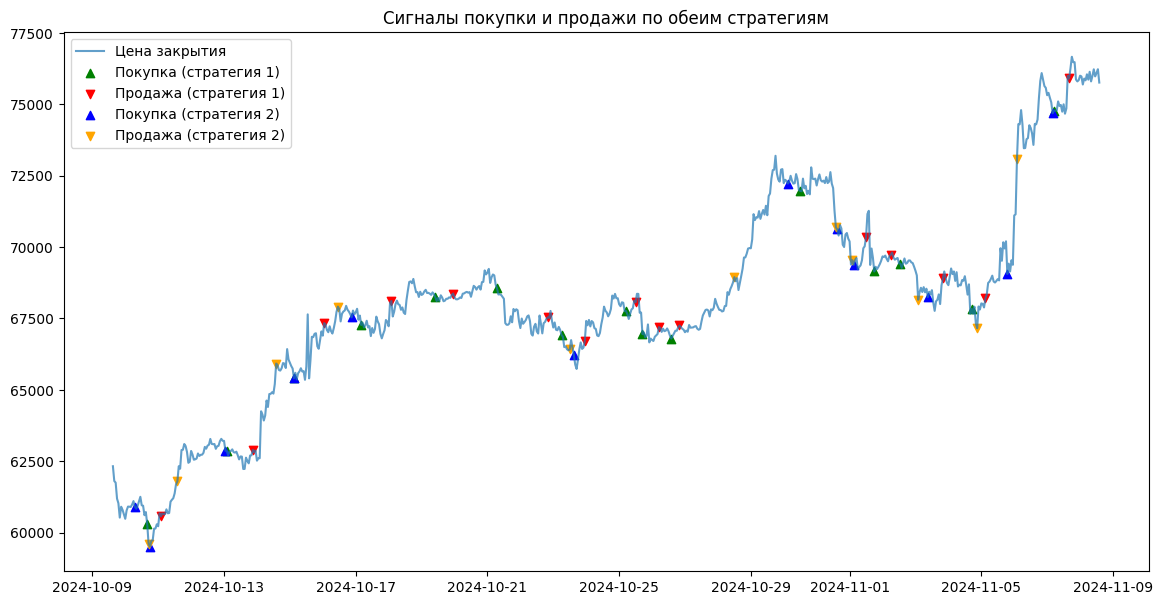

In [15]:
import talib as ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter

# Параметры стратегии
RSI_PERIOD_1 = 2
RSI_BUY_LEVEL_1 = 35
RSI_SELL_LEVEL_1 = 66

STOCH_K_PERIOD = 10
STOCH_D_PERIOD = 2
STOCH_OVERBOUGHT = 75
STOCH_OVERSOLD = 25

# Параметры второй стратегии
RSI_PERIOD_2 = 2
RSI_BUY_LEVEL_2 = 32
RSI_SELL_LEVEL_2 = 71

BBANDS_PERIOD = 16
BBANDS_STDDEV = 0.1

# Общие параметры для обеих стратегий
RISK_PERCENTAGE = 0.02  # Риск 1% от цены входа

# Функция для применения фильтра Калмана
def apply_kalman_filter(data):
    kf = KalmanFilter(transition_matrices=[1],
                      observation_matrices=[1],
                      initial_state_mean=0,
                      initial_state_covariance=1,
                      observation_covariance=1,
                      transition_covariance=0.01)
    state_means, _ = kf.filter(data)
    return state_means.flatten()

# Загрузка данных
data = get_data('kraken', '2024-04-01T00:00:00Z', '2024-05-31T00:00:00Z', '1h', 'BTC/USDT')
data.reset_index(inplace=True)

# Рассчитываем RSI для 1-й стратегии
data['RSI_1'] = ta.RSI(data['close'], timeperiod=RSI_PERIOD_1)

# Рассчитываем стохастик для 1-й стратегии
data['STOCH_K_1'], data['STOCH_D_1'] = ta.STOCH(data['high'], data['low'], data['close'],
                                                 fastk_period=STOCH_K_PERIOD,
                                                 slowk_period=STOCH_D_PERIOD,
                                                 slowk_matype=0,
                                                 slowd_period=STOCH_D_PERIOD,
                                                 slowd_matype=0)

# Рассчитываем RSI для 2-й стратегии
data['RSI_2'] = ta.RSI(data['close'], timeperiod=RSI_PERIOD_2)

# Рассчитываем полосы Боллинджера для 2-й стратегии
data['BB_upper'], data['BB_middle'], data['BB_lower'] = ta.BBANDS(data['close'], timeperiod=BBANDS_PERIOD,
                                                                   nbdevup=BBANDS_STDDEV, nbdevdn=BBANDS_STDDEV, matype=0)

# Создаем столбцы для сигналов и результатов
data['signal_1'] = 0
data['signal_2'] = 0
data['price_entry_1'] = np.nan
data['price_entry_2'] = np.nan
data['price_exit_1'] = np.nan
data['price_exit_2'] = np.nan
data['trade_result_1'] = np.nan
data['trade_result_2'] = np.nan

in_position_1 = False
in_position_2 = False
entry_price_1 = 0
entry_price_2 = 0
stop_loss_1 = np.nan
take_profit_1 = np.nan
stop_loss_2 = np.nan
take_profit_2 = np.nan

initial_capital = 10000
current_capital = initial_capital

# Логика первой стратегии с соотношением риска к прибыли 1:2
for i in range(1, len(data)):
    if not in_position_1:
        if data['RSI_1'][i] < RSI_BUY_LEVEL_1 and data['STOCH_K_1'][i] < STOCH_OVERSOLD and data['STOCH_D_1'][i] < STOCH_OVERSOLD:
            entry_price_1 = data['close'][i]
            risk_1 = RISK_PERCENTAGE * entry_price_1
            stop_loss_1 = entry_price_1 - risk_1
            take_profit_1 = entry_price_1 + 2 * risk_1
            data.at[i, 'signal_1'] = 1
            data.at[i, 'price_entry_1'] = entry_price_1
            in_position_1 = True
    else:
        if data['low'][i] <= stop_loss_1:
            data.at[i, 'signal_1'] = -1
            data.at[i, 'price_exit_1'] = stop_loss_1
            trade_return = (stop_loss_1 - entry_price_1) / entry_price_1 * 100
            data.at[i, 'trade_result_1'] = trade_return
            current_capital *= (1 + trade_return / 100)
            in_position_1 = False
        elif data['high'][i] >= take_profit_1:
            data.at[i, 'signal_1'] = -1
            data.at[i, 'price_exit_1'] = take_profit_1
            trade_return = (take_profit_1 - entry_price_1) / entry_price_1 * 100
            data.at[i, 'trade_result_1'] = trade_return
            current_capital *= (1 + trade_return / 100)
            in_position_1 = False

# Логика второй стратегии с соотношением риска к прибыли 1:2
    if not in_position_2:
        if data['RSI_2'][i] < RSI_BUY_LEVEL_2 and data['close'][i] <= data['BB_lower'][i]:
            entry_price_2 = data['close'][i]
            risk_2 = RISK_PERCENTAGE * entry_price_2
            stop_loss_2 = entry_price_2 - risk_2
            take_profit_2 = entry_price_2 + 2 * risk_2
            data.at[i, 'signal_2'] = 1
            data.at[i, 'price_entry_2'] = entry_price_2
            in_position_2 = True
    else:
        if data['low'][i] <= stop_loss_2:
            data.at[i, 'signal_2'] = -1
            data.at[i, 'price_exit_2'] = stop_loss_2
            trade_return = (stop_loss_2 - entry_price_2) / entry_price_2 * 100
            data.at[i, 'trade_result_2'] = trade_return
            current_capital *= (1 + trade_return / 100)
            in_position_2 = False
        elif data['high'][i] >= take_profit_2:
            data.at[i, 'signal_2'] = -1
            data.at[i, 'price_exit_2'] = take_profit_2
            trade_return = (take_profit_2 - entry_price_2) / entry_price_2 * 100
            data.at[i, 'trade_result_2'] = trade_return
            current_capital *= (1 + trade_return / 100)
            in_position_2 = False

# Выводим результаты сделок для обеих стратегий
trades_1 = data.dropna(subset=['trade_result_1'])
trades_2 = data.dropna(subset=['trade_result_2'])

# Общие результаты по обеим стратегиям
total_trades = len(trades_1) + len(trades_2)
successful_trades = len(trades_1[trades_1['trade_result_1'] > 0]) + len(trades_2[trades_2['trade_result_2'] > 0])
total_return = trades_1['trade_result_1'].sum() + trades_2['trade_result_2'].sum()
max_profit = max(trades_1['trade_result_1'].max(), trades_2['trade_result_2'].max())
max_loss = min(trades_1['trade_result_1'].min(), trades_2['trade_result_2'].min())

# Выводим общие результаты
print(f"Всего сделок: {total_trades}")
print(f"Успешные сделки: {successful_trades}")
print(f"Процент успешных сделок: {successful_trades / total_trades * 100:.2f}%")
print(f"Текущий капитал: {current_capital:.2f} USD")
print(f"Общая доходность: {(current_capital - initial_capital) / initial_capital * 100:.2f}%")
print(f"Максимальная прибыль: {max_profit:.2f}%")
print(f"Максимальный убыток: {max_loss:.2f}%")

# Визуализация
plt.figure(figsize=(14, 7))

# График цены закрытия
plt.plot(data['date'], data['close'], label='Цена закрытия', alpha=0.7)

# Сигналы по первой стратегии
plt.scatter(buy_signals_1['date'], buy_signals_1['close'], marker='^', color='green', label='Покупка (стратегия 1)', alpha=1)
plt.scatter(sell_signals_1['date'], sell_signals_1['close'], marker='v', color='red', label='Продажа (стратегия 1)', alpha=1)

# Сигналы по второй стратегии
buy_signals_2 = data[data['signal_2'] == 1]
sell_signals_2 = data[data['signal_2'] == -1]
plt.scatter(buy_signals_2['date'], buy_signals_2['close'], marker='^', color='blue', label='Покупка (стратегия 2)', alpha=1)
plt.scatter(sell_signals_2['date'], sell_signals_2['close'], marker='v', color='orange', label='Продажа (стратегия 2)', alpha=1)

plt.title('Сигналы покупки и продажи по обеим стратегиям')
plt.legend()
plt.show()


Всего сделок: 9
Успешные сделки: 7
Процент успешных сделок: 77.78%
Общая доходность: 28.54%
Максимальная прибыль: 11.48%
Максимальный убыток: -2.42%


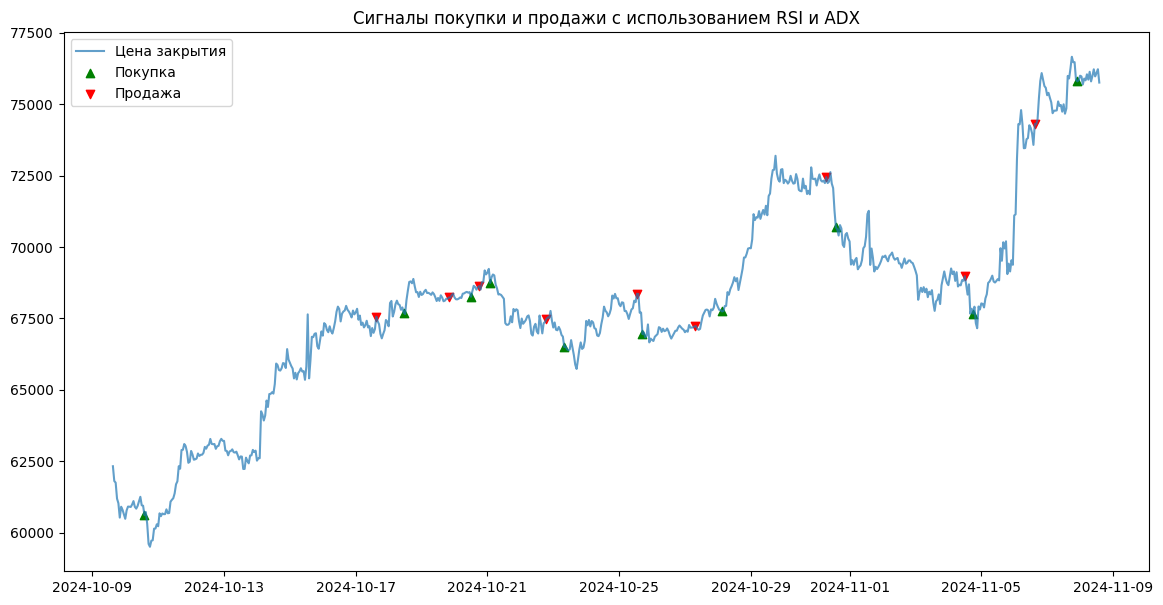

In [16]:
#@title RSI 3/2 + ADX
import talib as ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Параметры стратегии
RSI_PERIOD = 3 # 2 тоже хорошо работает
RSI_BUY_LEVEL = 30
RSI_SELL_LEVEL = 65
ADX_PERIOD = 10
ADX_THRESHOLD = 20

# Загрузка данных
data = get_data('kraken', '2024-04-01T00:00:00Z', '2024-05-31T00:00:00Z', '1h', 'BTC/USDT')
data.reset_index(inplace=True)

# Рассчитываем RSI
data['RSI'] = ta.RSI(data['close'], timeperiod=RSI_PERIOD)

# Рассчитываем ADX
data['ADX'] = ta.ADX(data['high'], data['low'], data['close'], timeperiod=ADX_PERIOD)

# Создаем столбцы для сигналов и результатов
data['signal'] = 0  # 1 — покупка, -1 — продажа, 0 — нет сигнала
data['price_entry'] = np.nan  # Цена входа в сделку
data['price_exit'] = np.nan  # Цена выхода
data['trade_result'] = np.nan  # Результат сделки в процентах

# Статусы для управления сделками
in_position = False
entry_price = 0

# Логика стратегии
for i in range(1, len(data)):
    if not in_position:  # Если мы не в позиции
        # Условие для покупки: RSI ниже уровня покупки и ADX выше порога
        if data['RSI'][i] < RSI_BUY_LEVEL and data['ADX'][i] > ADX_THRESHOLD:
            entry_price = data['close'][i]
            data.at[i, 'signal'] = 1  # Сигнал на покупку
            data.at[i, 'price_entry'] = entry_price
            in_position = True
    else:  # Если мы в позиции
        # Продаем, если RSI выше уровня продажи и ADX ниже порога
        if data['RSI'][i] > RSI_SELL_LEVEL and data['ADX'][i] < ADX_THRESHOLD:
            exit_price = data['close'][i]
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = exit_price
            data.at[i, 'trade_result'] = (exit_price - entry_price) / entry_price * 100
            in_position = False

# Выводим результаты сделок
trades = data.dropna(subset=['trade_result'])
print(f"Всего сделок: {len(trades)}")
print(f"Успешные сделки: {len(trades[trades['trade_result'] > 0])}")
print(f"Процент успешных сделок: {len(trades[trades['trade_result'] > 0]) / len(trades) * 100:.2f}%")
print(f"Общая доходность: {trades['trade_result'].sum():.2f}%")
print(f"Максимальная прибыль: {trades['trade_result'].max():.2f}%")
print(f"Максимальный убыток: {trades['trade_result'].min():.2f}%")

# Визуализация
plt.figure(figsize=(14, 7))

# График цены закрытия
plt.plot(data['date'], data['close'], label='Цена закрытия', alpha=0.7)
buy_signals = data[data['signal'] == 1]
sell_signals = data[data['signal'] == -1]
plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='green', label='Покупка', alpha=1)
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='red', label='Продажа', alpha=1)
plt.title('Сигналы покупки и продажи с использованием RSI и ADX')
plt.legend()

plt.show()

Всего сделок: 27
Успешные сделки: 16
Процент успешных сделок: 59.26%
Общая доходность: 27.29%
Максимальная прибыль: 7.34%
Максимальный убыток: -1.77%


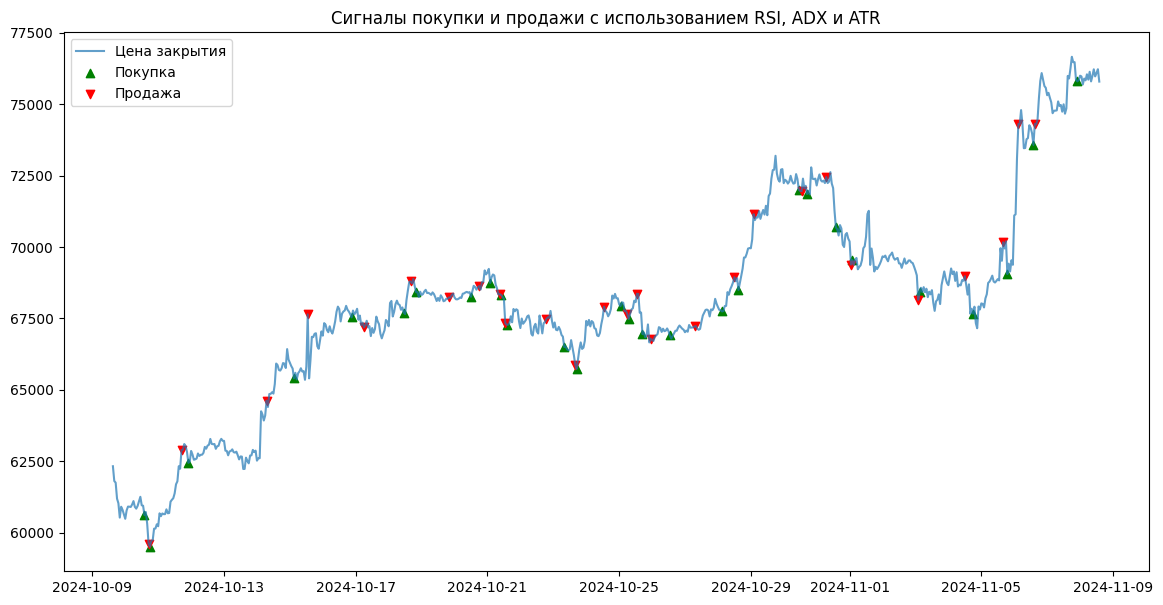

In [17]:
import talib as ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Параметры стратегии
RSI_PERIOD = 3
RSI_BUY_LEVEL = 30
RSI_SELL_LEVEL = 65
ADX_PERIOD = 10
ADX_THRESHOLD = 20
ATR_PERIOD = 2
ATR_MULTIPLIER_SL = 1.5  # Множитель для стоп-лосса
ATR_MULTIPLIER_TP = 5  # Множитель для тейк-профита

# Загрузка данных
data = get_data('kraken', '2024-04-01T00:00:00Z', '2024-05-31T00:00:00Z', '1h', 'BTC/USDT')
data.reset_index(inplace=True)

# Рассчитываем RSI
data['RSI'] = ta.RSI(data['close'], timeperiod=RSI_PERIOD)

# Рассчитываем ADX
data['ADX'] = ta.ADX(data['high'], data['low'], data['close'], timeperiod=ADX_PERIOD)

# Рассчитываем ATR
data['ATR'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=ATR_PERIOD)

# Создаем столбцы для сигналов и результатов
data['signal'] = 0  # 1 — покупка, -1 — продажа, 0 — нет сигнала
data['price_entry'] = np.nan  # Цена входа в сделку
data['price_exit'] = np.nan  # Цена выхода
data['trade_result'] = np.nan  # Результат сделки в процентах

# Статусы для управления сделками
in_position = False
entry_price = 0
stop_loss = np.nan
take_profit = np.nan

# Логика стратегии
for i in range(1, len(data)):
    if not in_position:  # Если мы не в позиции
        # Условие для покупки: RSI ниже уровня покупки и ADX выше порога
        if data['RSI'][i] < RSI_BUY_LEVEL and data['ADX'][i] > ADX_THRESHOLD:
            entry_price = data['close'][i]
            atr_value = data['ATR'][i]
            stop_loss = entry_price - ATR_MULTIPLIER_SL * atr_value  # Стоп-лосс на основе ATR
            take_profit = entry_price + ATR_MULTIPLIER_TP * atr_value  # Тейк-профит на основе ATR
            data.at[i, 'signal'] = 1  # Сигнал на покупку
            data.at[i, 'price_entry'] = entry_price
            in_position = True
    else:  # Если мы в позиции
        # Проверяем, достигли ли стоп-лосса или тейк-профита
        if data['low'][i] <= stop_loss:  # Стоп-лосс
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = stop_loss
            data.at[i, 'trade_result'] = (stop_loss - entry_price) / entry_price * 100
            in_position = False
        elif data['high'][i] >= take_profit:  # Тейк-профит
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = take_profit
            data.at[i, 'trade_result'] = (take_profit - entry_price) / entry_price * 100
            in_position = False
        # Продаем, если RSI выше уровня продажи и ADX ниже порога
        elif data['RSI'][i] > RSI_SELL_LEVEL and data['ADX'][i] < ADX_THRESHOLD:
            exit_price = data['close'][i]
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = exit_price
            data.at[i, 'trade_result'] = (exit_price - entry_price) / entry_price * 100
            in_position = False

# Выводим результаты сделок
trades = data.dropna(subset=['trade_result'])
print(f"Всего сделок: {len(trades)}")
print(f"Успешные сделки: {len(trades[trades['trade_result'] > 0])}")
print(f"Процент успешных сделок: {len(trades[trades['trade_result'] > 0]) / len(trades) * 100:.2f}%")
print(f"Общая доходность: {trades['trade_result'].sum():.2f}%")
print(f"Максимальная прибыль: {trades['trade_result'].max():.2f}%")
print(f"Максимальный убыток: {trades['trade_result'].min():.2f}%")

# Визуализация
plt.figure(figsize=(14, 7))

# График цены закрытия
plt.plot(data['date'], data['close'], label='Цена закрытия', alpha=0.7)
buy_signals = data[data['signal'] == 1]
sell_signals = data[data['signal'] == -1]
plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='green', label='Покупка', alpha=1)
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='red', label='Продажа', alpha=1)
plt.title('Сигналы покупки и продажи с использованием RSI, ADX и ATR')
plt.legend()

plt.show()

Всего сделок: 16
Успешные сделки: 11
Процент успешных сделок: 68.75%
Общая доходность: 16.04%
Максимальная прибыль: 9.08%
Максимальный убыток: -1.36%


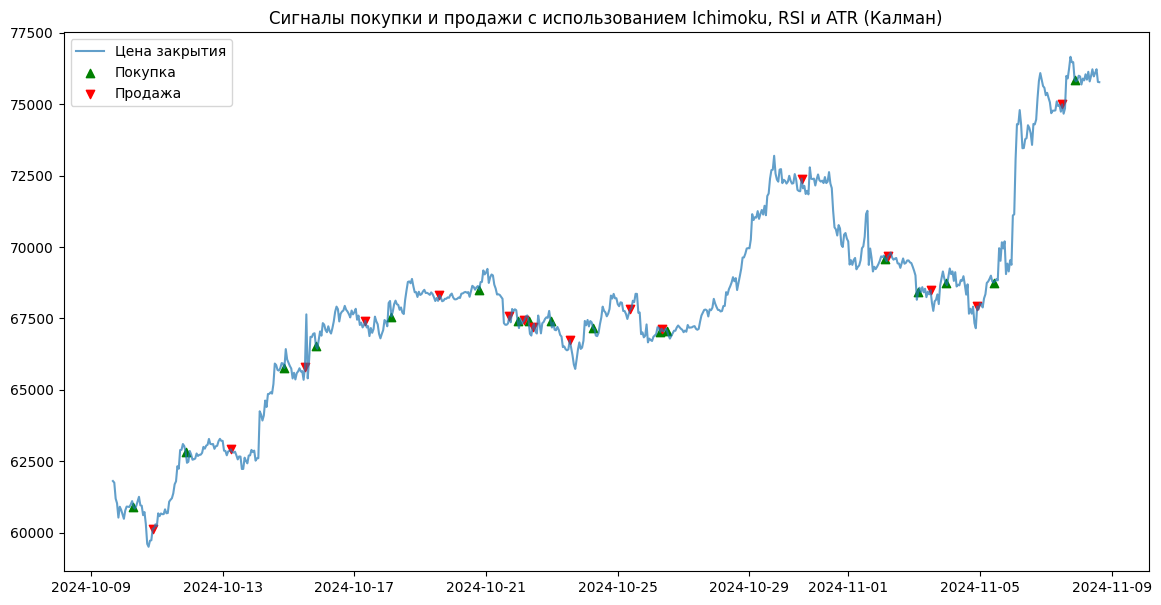

In [32]:
#@title RSI 2 + Ichimoku (ATR не работает вместе с Кальманом, это везде) // buy 35 sell 65
import talib as ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter

# Параметры стратегии
ICHIMOKU_TENKAN_SEN = 10
ICHIMOKU_KIJUN_SEN = 21
ICHIMOKU_SENKOU_SPAN_A = 52
ICHIMOKU_SENKOU_SPAN_B = 52
RSI_PERIOD = 2
RSI_BUY_LEVEL = 35
RSI_SELL_LEVEL = 65
ATR_PERIOD = 2
ATR_MULTIPLIER_SL = 0.75
ATR_MULTIPLIER_TP = 2.5

# Функция для применения фильтра Калмана
def apply_kalman_filter(data):
    kf = KalmanFilter(transition_matrices=[1],
                      observation_matrices=[1],
                      initial_state_mean=0,
                      initial_state_covariance=1,
                      observation_covariance=1,
                      transition_covariance=0.01)
    state_means, _ = kf.filter(data)
    return state_means.flatten()

# Загрузка данных
data = get_data('kraken', '2024-04-01T00:00:00Z', '2024-05-31T00:00:00Z', '1h', 'BTC/USDT')
data.reset_index(inplace=True)

# Рассчитываем Ichimoku
data['Tenkan-sen'] = (data['high'].rolling(window=ICHIMOKU_TENKAN_SEN).max() + data['low'].rolling(window=ICHIMOKU_TENKAN_SEN).min()) / 2
data['Kijun-sen'] = (data['high'].rolling(window=ICHIMOKU_KIJUN_SEN).max() + data['low'].rolling(window=ICHIMOKU_KIJUN_SEN).min()) / 2
data['Senkou Span A'] = (data['Tenkan-sen'] + data['Kijun-sen']) / 2
data['Senkou Span B'] = (data['high'].rolling(window=ICHIMOKU_SENKOU_SPAN_B).max() + data['low'].rolling(window=ICHIMOKU_SENKOU_SPAN_B).min()) / 2

# Рассчитываем RSI
data['RSI'] = ta.RSI(data['close'], timeperiod=RSI_PERIOD)

# Рассчитываем ATR
data['ATR'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=ATR_PERIOD)

# Применяем фильтр Калмана к значениям ATR
data['ATR_Kalman'] = apply_kalman_filter(data['ATR'])

# Создаем столбцы для сигналов и результатов
data['signal'] = 0  # 1 — покупка, -1 — продажа, 0 — нет сигнала
data['price_entry'] = np.nan  # Цена входа в сделку
data['price_exit'] = np.nan  # Цена выхода
data['trade_result'] = np.nan  # Результат сделки в процентах

# Статусы для управления сделками
in_position = False
entry_price = 0

# Логика стратегии
for i in range(1, len(data)):
    if not in_position:  # Если мы не в позиции
        # Условие для покупки: цена выше Tenkan-sen и RSI ниже уровня покупки
        if data['close'][i] > data['Tenkan-sen'][i] and data['RSI'][i] < RSI_BUY_LEVEL:
            entry_price = data['close'][i]
            atr_value = data['ATR_Kalman'][i]  # Используем сглаженный ATR с фильтром Калмана
            stop_loss = entry_price - ATR_MULTIPLIER_SL * atr_value  # Стоп-лосс на основе сглаженного ATR
            take_profit = entry_price + ATR_MULTIPLIER_TP * atr_value  # Тейк-профит на основе сглаженного ATR
            data.at[i, 'signal'] = 1  # Сигнал на покупку
            data.at[i, 'price_entry'] = entry_price
            in_position = True
    else:  # Если мы в позиции
        # Проверяем, достигли ли стоп-лосса или тейк-профита
        if data['low'][i] <= stop_loss:  # Стоп-лосс
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = stop_loss
            data.at[i, 'trade_result'] = (stop_loss - entry_price) / entry_price * 100
            in_position = False
        elif data['high'][i] >= take_profit:  # Тейк-профит
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = take_profit
            data.at[i, 'trade_result'] = (take_profit - entry_price) / entry_price * 100
            in_position = False
        # Продаем, если цена ниже Kijun-sen и RSI выше уровня продажи
        elif data['close'][i] < data['Kijun-sen'][i] and data['RSI'][i] > RSI_SELL_LEVEL:
            exit_price = data['close'][i]
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = exit_price
            data.at[i, 'trade_result'] = (exit_price - entry_price) / entry_price * 100
            in_position = False

# Выводим результаты сделок
trades = data.dropna(subset=['trade_result'])
print(f"Всего сделок: {len(trades)}")
print(f"Успешные сделки: {len(trades[trades['trade_result'] > 0])}")
print(f"Процент успешных сделок: {len(trades[trades['trade_result'] > 0]) / len(trades) * 100:.2f}%")
print(f"Общая доходность: {trades['trade_result'].sum():.2f}%")
print(f"Максимальная прибыль: {trades['trade_result'].max():.2f}%")
print(f"Максимальный убыток: {trades['trade_result'].min():.2f}%")

# Визуализация
plt.figure(figsize=(14, 7))

# График цены закрытия
plt.plot(data['date'], data['close'], label='Цена закрытия', alpha=0.7)
buy_signals = data[data['signal'] == 1]
sell_signals = data[data['signal'] == -1]
plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='green', label='Покупка', alpha=1)
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='red', label='Продажа', alpha=1)
plt.title('Сигналы покупки и продажи с использованием Ichimoku, RSI и ATR (Калман)')
plt.legend()

plt.show()

Всего сделок: 16
Успешные сделки: 10
Процент успешных сделок: 62.50%
Общая доходность: 21.50%
Максимальная прибыль: 8.17%
Максимальный убыток: -1.15%


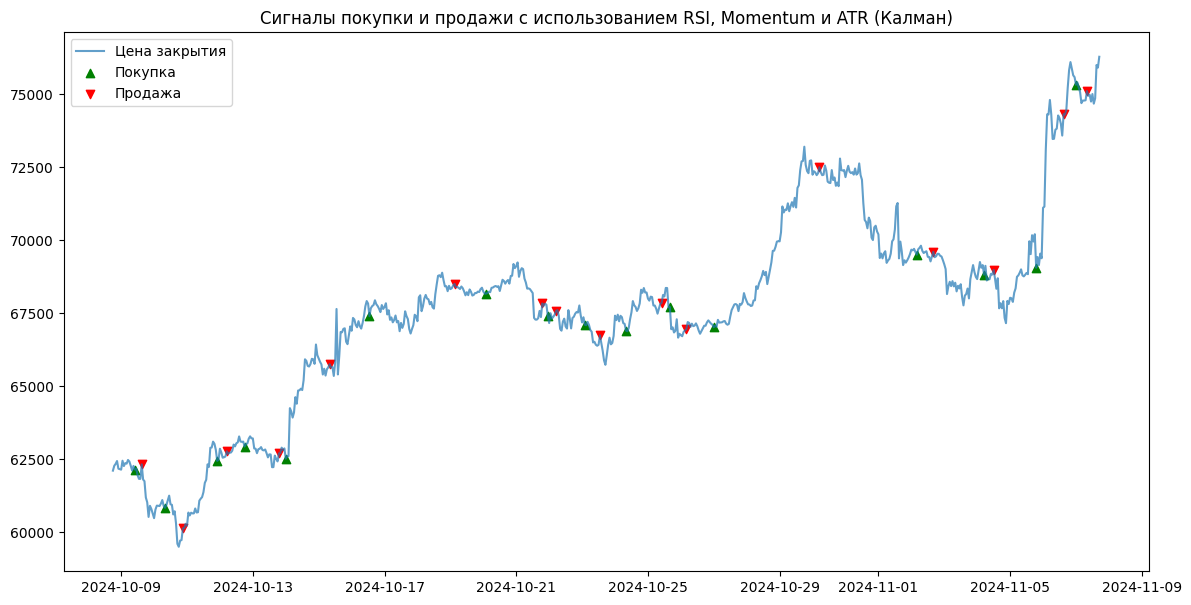

In [ ]:
#@title RSI 2 + Momentum + ATR Kalman // buy 35 sell 65
import talib as ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter

# Параметры стратегии
RSI_PERIOD = 3
RSI_BUY_LEVEL = 35
RSI_SELL_LEVEL = 65
MOMENTUM_PERIOD = 10
ATR_PERIOD = 2
ATR_MULTIPLIER_SL = 0.75
ATR_MULTIPLIER_TP = 2.5

# Функция для применения фильтра Калмана
def apply_kalman_filter(data):
    kf = KalmanFilter(transition_matrices=[1],
                      observation_matrices=[1],
                      initial_state_mean=0,
                      initial_state_covariance=1,
                      observation_covariance=1,
                      transition_covariance=0.01)
    state_means, _ = kf.filter(data)
    return state_means.flatten()

# Загрузка данных
data = get_data('kraken', '2024-04-01T00:00:00Z', '2024-05-31T00:00:00Z', '1h', 'BTC/USDT')
data.reset_index(inplace=True)

# Рассчитываем RSI
data['RSI'] = ta.RSI(data['close'], timeperiod=RSI_PERIOD)

# Рассчитываем Momentum
data['Momentum'] = ta.MOM(data['close'], timeperiod=MOMENTUM_PERIOD)

# Рассчитываем ATR
data['ATR'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=ATR_PERIOD)

# Применяем фильтр Калмана к значениям ATR
data['ATR_Kalman'] = apply_kalman_filter(data['ATR'])

# Создаем столбцы для сигналов и результатов
data['signal'] = 0  # 1 — покупка, -1 — продажа, 0 — нет сигнала
data['price_entry'] = np.nan  # Цена входа в сделку
data['price_exit'] = np.nan  # Цена выхода
data['trade_result'] = np.nan  # Результат сделки в процентах

# Статусы для управления сделками
in_position = False
entry_price = 0

# Логика стратегии
for i in range(1, len(data)):
    if not in_position:  # Если мы не в позиции
        # Условие для покупки: RSI ниже уровня покупки и Momentum выше нуля
        if data['RSI'][i] < RSI_BUY_LEVEL and data['Momentum'][i] > 0:
            entry_price = data['close'][i]
            atr_value = data['ATR_Kalman'][i]  # Используем сглаженный ATR с фильтром Калмана
            stop_loss = entry_price - ATR_MULTIPLIER_SL * atr_value  # Стоп-лосс на основе сглаженного ATR
            take_profit = entry_price + ATR_MULTIPLIER_TP * atr_value  # Тейк-профит на основе сглаженного ATR
            data.at[i, 'signal'] = 1  # Сигнал на покупку
            data.at[i, 'price_entry'] = entry_price
            in_position = True
    else:  # Если мы в позиции
        # Проверяем, достигли ли стоп-лосса или тейк-профита
        if data['low'][i] <= stop_loss:  # Стоп-лосс
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = stop_loss
            data.at[i, 'trade_result'] = (stop_loss - entry_price) / entry_price * 100
            in_position = False
        elif data['high'][i] >= take_profit:  # Тейк-профит
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = take_profit
            data.at[i, 'trade_result'] = (take_profit - entry_price) / entry_price * 100
            in_position = False
        # Продаем, если RSI выше уровня продажи и Momentum ниже нуля
        elif data['RSI'][i] > RSI_SELL_LEVEL and data['Momentum'][i] < 0:
            exit_price = data['close'][i]
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = exit_price
            data.at[i, 'trade_result'] = (exit_price - entry_price) / entry_price * 100
            in_position = False

# Выводим результаты сделок
trades = data.dropna(subset=['trade_result'])
print(f"Всего сделок: {len(trades)}")
print(f"Успешные сделки: {len(trades[trades['trade_result'] > 0])}")
print(f"Процент успешных сделок: {len(trades[trades['trade_result'] > 0]) / len(trades) * 100:.2f}%")
print(f"Общая доходность: {trades['trade_result'].sum():.2f}%")
print(f"Максимальная прибыль: {trades['trade_result'].max():.2f}%")
print(f"Максимальный убыток: {trades['trade_result'].min():.2f}%")

# Визуализация
plt.figure(figsize=(14, 7))

# График цены закрытия
plt.plot(data['date'], data['close'], label='Цена закрытия', alpha=0.7)
buy_signals = data[data['signal'] == 1]
sell_signals = data[data['signal'] == -1]
plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='green', label='Покупка', alpha=1)
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='red', label='Продажа', alpha=1)
plt.title('Сигналы покупки и продажи с использованием RSI, Momentum и ATR (Калман)')
plt.legend()

plt.show()

Всего сделок: 12
Успешные сделки: 11
Процент успешных сделок: 91.67%
Общая доходность: 14.23%
Максимальная прибыль: 3.51%
Максимальный убыток: -0.16%


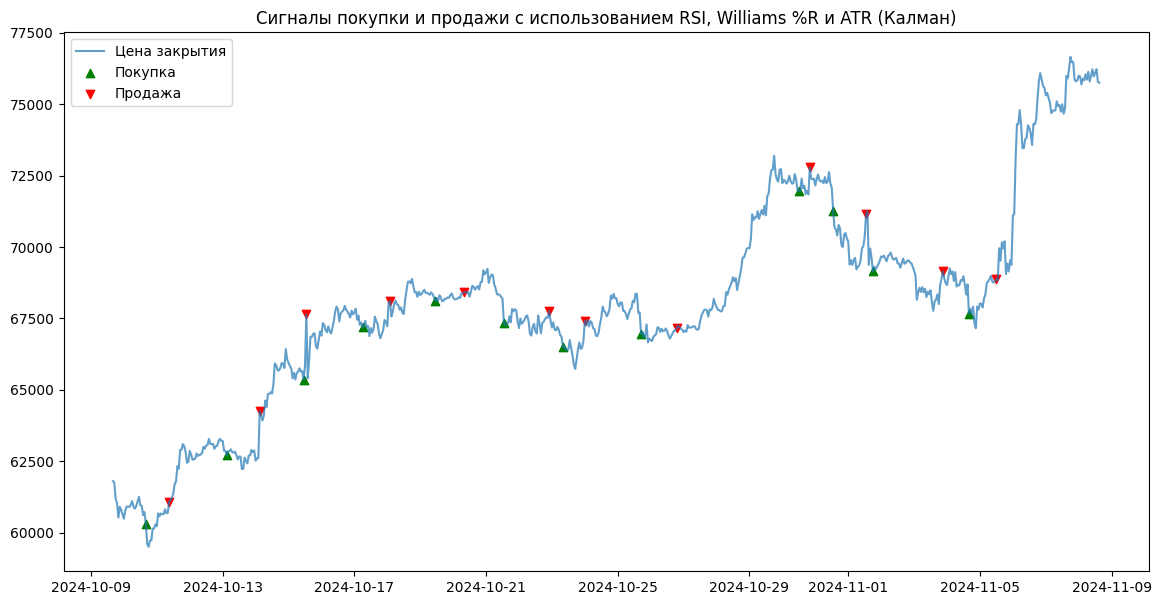

In [33]:
#@title RSI 2 + Williams + ATR Kalman // buy 35 sell 65
import talib as ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter

# Параметры стратегии
RSI_PERIOD = 2 # Тут в SL как таковой смысл отсуствует по природе индикатора
RSI_BUY_LEVEL = 30
RSI_SELL_LEVEL = 65
WILLIAMS_PERIOD = 21
WILLIAMS_BUY_LEVEL = -90
WILLIAMS_SELL_LEVEL = -10
ATR_PERIOD = 2
ATR_MULTIPLIER_SL = 0.6
ATR_MULTIPLIER_TP = 2.5

# Функция для применения фильтра Калмана
def apply_kalman_filter(data):
    kf = KalmanFilter(transition_matrices=[1],
                      observation_matrices=[1],
                      initial_state_mean=0,
                      initial_state_covariance=1,
                      observation_covariance=1,
                      transition_covariance=0.01)
    state_means, _ = kf.filter(data)
    return state_means.flatten()

# Загрузка данных
data = get_data('kraken', '2024-04-01T00:00:00Z', '2024-05-31T00:00:00Z', '1h', 'BTC/USDT')
data.reset_index(inplace=True)

# Рассчитываем RSI
data['RSI'] = ta.RSI(data['close'], timeperiod=RSI_PERIOD)

# Рассчитываем Williams %R
data['Williams'] = ta.WILLR(data['high'], data['low'], data['close'], timeperiod=WILLIAMS_PERIOD)

# Рассчитываем ATR
data['ATR'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=ATR_PERIOD)

# Применяем фильтр Калмана к значениям ATR
data['ATR_Kalman'] = apply_kalman_filter(data['ATR'])

# Создаем столбцы для сигналов и результатов
data['signal'] = 0  # 1 — покупка, -1 — продажа, 0 — нет сигнала
data['price_entry'] = np.nan  # Цена входа в сделку
data['price_exit'] = np.nan  # Цена выхода
data['trade_result'] = np.nan  # Результат сделки в процентах

# Статусы для управления сделками
in_position = False
entry_price = 0

# Логика стратегии
for i in range(1, len(data)):
    if not in_position:  # Если мы не в позиции
        # Условие для покупки: RSI ниже уровня покупки и Williams %R ниже уровня покупки
        if data['RSI'][i] < RSI_BUY_LEVEL and data['Williams'][i] < WILLIAMS_BUY_LEVEL:
            entry_price = data['close'][i]
            atr_value = data['ATR_Kalman'][i]  # Используем сглаженный ATR с фильтром Калмана
            stop_loss = entry_price - ATR_MULTIPLIER_SL * atr_value  # Стоп-лосс на основе сглаженного ATR
            take_profit = entry_price + ATR_MULTIPLIER_TP * atr_value  # Тейк-профит на основе сглаженного ATR
            data.at[i, 'signal'] = 1  # Сигнал на покупку
            data.at[i, 'price_entry'] = entry_price
            in_position = True
    else:  # Если мы в позиции
        # Проверяем, достигли ли стоп-лосса или тейк-профита
        if data['low'][i] <= stop_loss:  # Стоп-лосс
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = stop_loss
            data.at[i, 'trade_result'] = (stop_loss - entry_price) / entry_price * 100
            in_position = False
        elif data['high'][i] >= take_profit:  # Тейк-профит
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = take_profit
            data.at[i, 'trade_result'] = (take_profit - entry_price) / entry_price * 100
            in_position = False
        # Продаем, если RSI выше уровня продажи и Williams %R выше уровня продажи
        elif data['RSI'][i] > RSI_SELL_LEVEL and data['Williams'][i] > WILLIAMS_SELL_LEVEL:
            exit_price = data['close'][i]
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = exit_price
            data.at[i, 'trade_result'] = (exit_price - entry_price) / entry_price * 100
            in_position = False

# Выводим результаты сделок
trades = data.dropna(subset=['trade_result'])
print(f"Всего сделок: {len(trades)}")
print(f"Успешные сделки: {len(trades[trades['trade_result'] > 0])}")
print(f"Процент успешных сделок: {len(trades[trades['trade_result'] > 0]) / len(trades) * 100:.2f}%")
print(f"Общая доходность: {trades['trade_result'].sum():.2f}%")
print(f"Максимальная прибыль: {trades['trade_result'].max():.2f}%")
print(f"Максимальный убыток: {trades['trade_result'].min():.2f}%")

# Визуализация
plt.figure(figsize=(14, 7))

# График цены закрытия
plt.plot(data['date'], data['close'], label='Цена закрытия', alpha=0.7)
buy_signals = data[data['signal'] == 1]
sell_signals = data[data['signal'] == -1]
plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='green', label='Покупка', alpha=1)
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='red', label='Продажа', alpha=1)
plt.title('Сигналы покупки и продажи с использованием RSI, Williams %R и ATR (Калман)')
plt.legend()

plt.show()

Всего сделок: 62
Успешные сделки: 48
Процент успешных сделок: 77.42%
Общая доходность: 21.43%
Максимальная прибыль: 3.51%
Максимальный убыток: -3.51%


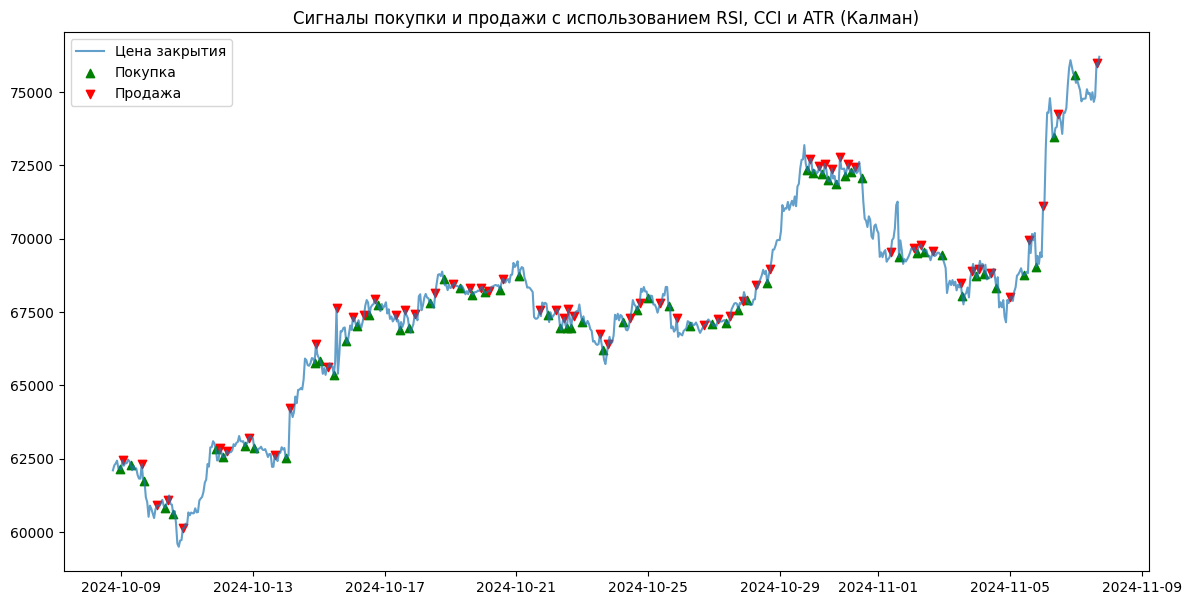

In [ ]:
#@title RSI 2 + CCI + Kalman ATR // buy 35 sell 65
import talib as ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter

# Параметры стратегии
RSI_PERIOD = 2
RSI_BUY_LEVEL = 35
RSI_SELL_LEVEL = 65
CCI_PERIOD = 3
CCI_BUY_LEVEL = -85
CCI_SELL_LEVEL = 95
ATR_PERIOD = 2
ATR_MULTIPLIER_SL = 0.6
ATR_MULTIPLIER_TP = 2.5

# Функция для применения фильтра Калмана
def apply_kalman_filter(data):
    kf = KalmanFilter(transition_matrices=[1],
                      observation_matrices=[1],
                      initial_state_mean=0,
                      initial_state_covariance=1,
                      observation_covariance=1,
                      transition_covariance=0.01)
    state_means, _ = kf.filter(data)
    return state_means.flatten()

# Загрузка данных
data = get_data('kraken', '2024-04-01T00:00:00Z', '2024-05-31T00:00:00Z', '1h', 'BTC/USDT')
data.reset_index(inplace=True)

# Рассчитываем RSI
data['RSI'] = ta.RSI(data['close'], timeperiod=RSI_PERIOD)

# Рассчитываем CCI
data['CCI'] = ta.CCI(data['high'], data['low'], data['close'], timeperiod=CCI_PERIOD)

# Рассчитываем ATR
data['ATR'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=ATR_PERIOD)

# Применяем фильтр Калмана к значениям ATR
data['ATR_Kalman'] = apply_kalman_filter(data['ATR'])

# Создаем столбцы для сигналов и результатов
data['signal'] = 0  # 1 — покупка, -1 — продажа, 0 — нет сигнала
data['price_entry'] = np.nan  # Цена входа в сделку
data['price_exit'] = np.nan  # Цена выхода
data['trade_result'] = np.nan  # Результат сделки в процентах

# Статусы для управления сделками
in_position = False
entry_price = 0

# Логика стратегии
for i in range(1, len(data)):
    if not in_position:  # Если мы не в позиции
        # Условие для покупки: RSI ниже уровня покупки и CCI ниже уровня покупки
        if data['RSI'][i] < RSI_BUY_LEVEL and data['CCI'][i] < CCI_BUY_LEVEL:
            entry_price = data['close'][i]
            atr_value = data['ATR_Kalman'][i]  # Используем сглаженный ATR с фильтром Калмана
            stop_loss = entry_price - ATR_MULTIPLIER_SL * atr_value  # Стоп-лосс на основе сглаженного ATR
            take_profit = entry_price + ATR_MULTIPLIER_TP * atr_value  # Тейк-профит на основе сглаженного ATR
            data.at[i, 'signal'] = 1  # Сигнал на покупку
            data.at[i, 'price_entry'] = entry_price
            in_position = True
    else:  # Если мы в позиции
        # Проверяем, достигли ли стоп-лосса или тейк-профита
        if data['low'][i] <= stop_loss:  # Стоп-лосс
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = stop_loss
            data.at[i, 'trade_result'] = (stop_loss - entry_price) / entry_price * 100
            in_position = False
        elif data['high'][i] >= take_profit:  # Тейк-профит
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = take_profit
            data.at[i, 'trade_result'] = (take_profit - entry_price) / entry_price * 100
            in_position = False
        # Продаем, если RSI выше уровня продажи и CCI выше уровня продажи
        elif data['RSI'][i] > RSI_SELL_LEVEL and data['CCI'][i] > CCI_SELL_LEVEL:
            exit_price = data['close'][i]
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = exit_price
            data.at[i, 'trade_result'] = (exit_price - entry_price) / entry_price * 100
            in_position = False

# Выводим результаты сделок
trades = data.dropna(subset=['trade_result'])
print(f"Всего сделок: {len(trades)}")
print(f"Успешные сделки: {len(trades[trades['trade_result'] > 0])}")
print(f"Процент успешных сделок: {len(trades[trades['trade_result'] > 0]) / len(trades) * 100:.2f}%")
print(f"Общая доходность: {trades['trade_result'].sum():.2f}%")
print(f"Максимальная прибыль: {trades['trade_result'].max():.2f}%")
print(f"Максимальный убыток: {trades['trade_result'].min():.2f}%")

# Визуализация
plt.figure(figsize=(14, 7))

# График цены закрытия
plt.plot(data['date'], data['close'], label='Цена закрытия', alpha=0.7)
buy_signals = data[data['signal'] == 1]
sell_signals = data[data['signal'] == -1]
plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='green', label='Покупка', alpha=1)
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='red', label='Продажа', alpha=1)
plt.title('Сигналы покупки и продажи с использованием RSI, CCI и ATR (Калман)')
plt.legend()

plt.show()

Всего сделок: 82
Успешные сделки: 50
Процент успешных сделок: 60.98%
Общая доходность: 23.06%
Максимальная прибыль: 3.51%
Максимальный убыток: -1.13%


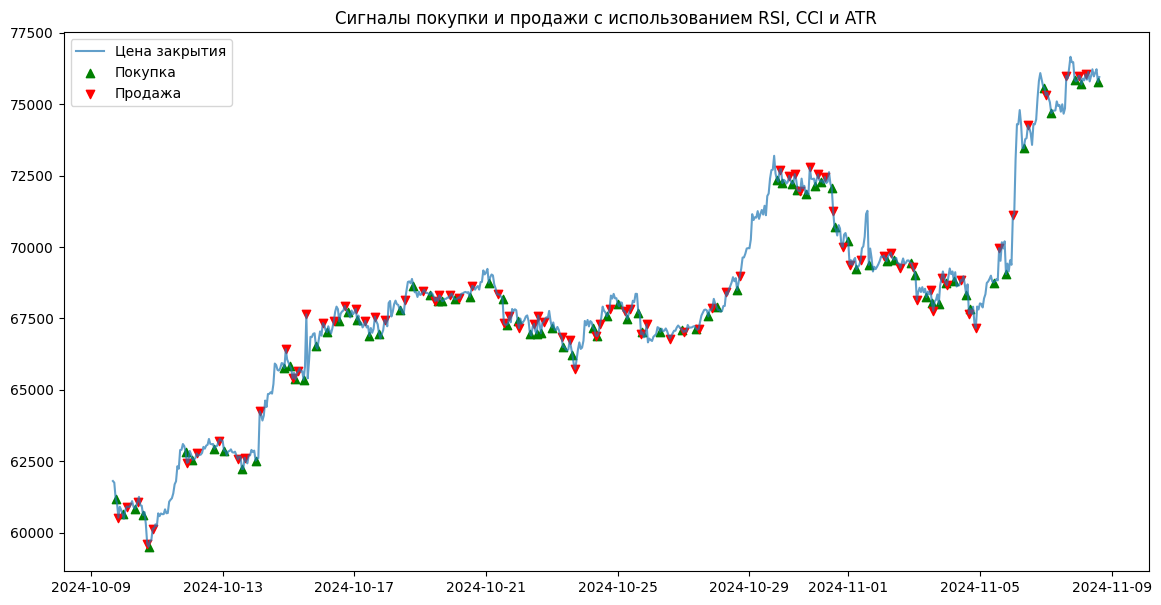

In [39]:
import talib as ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Параметры стратегии
RSI_PERIOD = 2
RSI_BUY_LEVEL = 35
RSI_SELL_LEVEL = 65
CCI_PERIOD = 3
CCI_BUY_LEVEL = -85
CCI_SELL_LEVEL = 95
ATR_PERIOD = 2
ATR_MULTIPLIER_SL = 1 # При использрвании Стопа по ATR доходность повысилась на 2 процента
ATR_MULTIPLIER_TP = 10

# Загрузка данных
data = get_data('kraken', '2024-04-01T00:00:00Z', '2024-05-31T00:00:00Z', '1h', 'BTC/USDT')
data.reset_index(inplace=True)

# Рассчитываем RSI
data['RSI'] = ta.RSI(data['close'], timeperiod=RSI_PERIOD)

# Рассчитываем CCI
data['CCI'] = ta.CCI(data['high'], data['low'], data['close'], timeperiod=CCI_PERIOD)

# Рассчитываем ATR
data['ATR'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=ATR_PERIOD)

# Создаем столбцы для сигналов и результатов
data['signal'] = 0  # 1 — покупка, -1 — продажа, 0 — нет сигнала
data['price_entry'] = np.nan  # Цена входа в сделку
data['price_exit'] = np.nan  # Цена выхода
data['trade_result'] = np.nan  # Результат сделки в процентах

# Статусы для управления сделками
in_position = False
entry_price = 0
stop_loss = np.nan
take_profit = np.nan

# Логика стратегии
for i in range(1, len(data)):
    if not in_position:  # Если мы не в позиции
        # Условие для покупки: RSI ниже уровня покупки и CCI ниже уровня покупки
        if data['RSI'][i] < RSI_BUY_LEVEL and data['CCI'][i] < CCI_BUY_LEVEL:
            entry_price = data['close'][i]
            atr_value = data['ATR'][i]
            stop_loss = entry_price - ATR_MULTIPLIER_SL * atr_value  # Стоп-лосс на основе ATR
            take_profit = entry_price + ATR_MULTIPLIER_TP * atr_value  # Тейк-профит на основе ATR
            data.at[i, 'signal'] = 1  # Сигнал на покупку
            data.at[i, 'price_entry'] = entry_price
            in_position = True
    else:  # Если мы в позиции
        # Проверяем, достигли ли стоп-лосса или тейк-профита
        if data['low'][i] <= stop_loss:  # Стоп-лосс
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = stop_loss
            data.at[i, 'trade_result'] = (stop_loss - entry_price) / entry_price * 100
            in_position = False
        elif data['high'][i] >= take_profit:  # Тейк-профит
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = take_profit
            data.at[i, 'trade_result'] = (take_profit - entry_price) / entry_price * 100
            in_position = False
        # Продаем, если RSI выше уровня продажи и CCI выше уровня продажи
        elif data['RSI'][i] > RSI_SELL_LEVEL and data['CCI'][i] > CCI_SELL_LEVEL:
            exit_price = data['close'][i]
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = exit_price
            data.at[i, 'trade_result'] = (exit_price - entry_price) / entry_price * 100
            in_position = False

# Выводим результаты сделок
trades = data.dropna(subset=['trade_result'])
print(f"Всего сделок: {len(trades)}")
print(f"Успешные сделки: {len(trades[trades['trade_result'] > 0])}")
print(f"Процент успешных сделок: {len(trades[trades['trade_result'] > 0]) / len(trades) * 100:.2f}%")
print(f"Общая доходность: {trades['trade_result'].sum():.2f}%")
print(f"Максимальная прибыль: {trades['trade_result'].max():.2f}%")
print(f"Максимальный убыток: {trades['trade_result'].min():.2f}%")

# Визуализация
plt.figure(figsize=(14, 7))

# График цены закрытия
plt.plot(data['date'], data['close'], label='Цена закрытия', alpha=0.7)
buy_signals = data[data['signal'] == 1]
sell_signals = data[data['signal'] == -1]
plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='green', label='Покупка', alpha=1)
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='red', label='Продажа', alpha=1)
plt.title('Сигналы покупки и продажи с использованием RSI, CCI и ATR')
plt.legend()

plt.show()

In [ ]:
!pip install ccxt pywavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 18.1 MB/s eta 0:00:00


In [ ]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 6.9 MB/s eta 0:00:00
